# Interconnect predicción de abandono de clientes

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
    * [1.1. Importación de librerías y datos](#importation)
    * [1.2. Descripción inicial de los datos](#decription)
    * [1.3. Preparación inicial de los datos](#pre-process-1)
* [2. Análisis exploratorio de los datos](#data_analysis)
* [3. Preparación de los datos para los modelos](#data_preprocessing)  
    * [3.1. Selección de características y objetivos](#feature_selection)  
    * [3.2. Balanceo de clases](#balance)
    * [3.3. Codificación y estandarización de características](#codification)
    * [3.4. Segmentación de conjuntos en entrenamiento y pruebas](#segmentation)
* [4. Entrenamiento del modelo predictivo](#model_prediction)  
    * [4.1. Regresión Logística](#regression)  
    * [4.2. Bosque Aleatorio de Clasificación](#random_forest)
    * [4.3. XGBoost Classifier](#xgboost)
* [5. Predicciones en el conjunto de prueba](#predict_test)   
    * [5.1. Selección del modelo](#model_select)
    * [5.2. Predicciones y evaluación del modelo](#model_eval)
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente.

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.  
Métrica principal: AUC-ROC.  
Métrica adicional: exactitud.  
Criterios de aceptabilidad: AUC-ROC ≥ 0.88 

### Plan aproximado del proyecto

**1. Descripción y preparación de los datos:** se leerá la información de las tablas y se determinará la calidad de los datos, se solucionarán problemas con nulos, duplicados y tipado de los datos.
    
**2. Análisis exploratorio de los datos:** se preparará un análisis descriptivo de las variables más interesantes, preparando hipótesis de los datos, con un enfoque en la pérdida de clientes y el balance de la variable objetiva.

**3. Preparación de los datos para los modelos:** se seleccionarán las características y se propondrán los modelos más atractivos para la tarea de clasificación, se prepararán los datos para que funcionen como entrada de los diferentes modelos, además de desglosarlos en 2 subconjuntos; entrenamiento y prueba.
    
**4. Entrenamiento del modelo predictivo:** se estudiará el rendimiento de los modelos en el conjunto de validación con diferentes métricas; exactitud, recall, F1, F2 y AUC-ROC. También se usará la validación cruzada para dar robustez al estudio y se tendrá en cuenta si existe sobre ajuste en los modelos seleccionados.
   
**5. Predicciones en el conjunto de prueba:** con las conclusiones obtenidas en los entrenamientos del punto anterior, se pondrán a prueba los modelos para realizar una evaluación final que retorne conclusiones, recomendaciones y resultados para un modelo predictivo de la pérdida de clientes.

## 1. Descripción y preparación de los datos <a id="data_review"></a>

### 1.1. Importación de librerías y datos. <a id="importation"></a>

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Leemos los datos de información de contratos
df_contract = pd.read_csv('../files/datasets/input/final_provider/contract.csv')

In [3]:
# Leemos los datos personales de clientes
df_personal = pd.read_csv('../files/datasets/input/final_provider/personal.csv')

In [4]:
# Leemos los datos de los servicios de internet
df_internet = pd.read_csv('../files/datasets/input/final_provider/internet.csv')

In [5]:
# Leemos los datos de los servicios telefónicos
df_phone = pd.read_csv('../files/datasets/input/final_provider/phone.csv')

### 1.2. Descripción inicial de los datos. <a id="decription"></a>

#### Datos de contratos

In [6]:
# Información y estadísticas descriptivas de los contratos
print(df_contract.info())
print('---'*20)
print(df_contract.describe())
print('---'*20)
print(df_contract.describe(include='object'))
df_contract.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
------------------------------------------------------------
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
------------------------------------------------------------
        customerID   BeginDate EndDate       

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


Según la descripción y estadísticas de los datos de contratos (`df_contract`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 7043 entradas únicas en customerID, es decir, no hay contratos repetidos.
- Evidenciamos necesidades de cambios en el tipo de dato de las columnas BeginDate(cambiar a datetime), EndDate(cambiar a datetime), PaperlessBilling(cambiar a int 0/1), TotalCharges(cambiar a float).
- Se requiere separar la columna EndDate en dos, la primera que almacene las fechas de terminación en formato datetime y la segunda que almacene la variable objetivo, si un cliente ha abandonado o no en formato int (IsChurn).
- No hay incoherencias en los rangos numéricos de MonthlyCharges.
- Identificamos 3 tipos de entradas en la columna Type y 4 en PaymentMethod que validaremos. 

In [7]:
# Validación de entradas únicas en columnas clave
print(df_contract['Type'].unique())
print(df_contract['PaymentMethod'].unique())

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Los valores de las columnas categoricas principales no muestran entradas corrompidas o incoherentes.

#### Datos personales

In [8]:
# Información y estadísticas descriptivas de datos personales
print(df_personal.info())
print('---'*20)
print(df_personal.describe())
print('---'*20)
print(df_personal.describe(include='object'))
df_personal.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
------------------------------------------------------------
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
------------------------------------------------------------
        customerID gender Partner Dependents
count         7043   7043    7043       7043
unique        7043      2       2          2
top     3186-AJIEK   Male      No         No
freq             1   3555    3641       4933


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Según la descripción y estadísticas de los datos personales (`df_personal`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 7043 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- Evidenciamos necesidades de cambios en el tipo de dato de las columnas Partner(cambiar a int 0/1) y Dependents(cambiar a int 0/1).
- No hay incoherencias en los rangos numéricos de SeniorCitizen.
- Identificamos 2 tipos de entradas en la columna gender (Female y Male).

In [9]:
# Validación de entradas únicas en columnas clave
print(df_personal['gender'].unique())
print(df_personal['SeniorCitizen'].unique())

['Female' 'Male']
[0 1]


Los valores de las columnas categoricas principales no muestran entradas corrompidas o incoherentes.

#### Datos de internet

In [10]:
# Información y estadísticas descriptivas de datos de internet
print(df_internet.info())
print('---'*20)
print(df_internet.describe())
df_internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
------------------------------------------------------------
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


Según la descripción y estadísticas de los datos personales (`df_internet`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 5517 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- Todas las columnas son categorías transferibles al tipo int 0/1.
- Existen 2 tipos de entradas en la columna InternetService (DSL y Fiber optic).

In [11]:
# Validación de entradas únicas en columnas clave
print(df_internet['InternetService'].unique())

['DSL' 'Fiber optic']


Los valores de la columnas categorica principal no muestra entradas corrompidas o incoherentes.

#### Datos telefónicos

In [12]:
# Información y estadísticas descriptivas de datos telefónicos
print(df_phone.info())
print('---'*20)
print(df_phone.describe())
df_phone.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
------------------------------------------------------------
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3186-AJIEK            No
freq             1          3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Según la descripción y estadísticas de los datos personales (`df_phone`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 6361 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- La columna MultipleLines es transferible al tipo int 0/1.

### 1.3. Preparación inicial de los datos. <a id="pre-process-1"></a>

En esta sección se ajustarán las observaciones realizadas en la sección anterior, para que los datos estén listos para el análisis exploratorio y la preparación de los datos para los modelos.

#### Datos de contratos

In [13]:
# Cambio de tipo de datos de la columna 'BeginDate' a datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate']).dt.date

In [14]:
# Creación de la columna 'IsChurned'
df_contract['IsChurn'] = df_contract['EndDate'].map(lambda x: 1 if x != 'No' else 0)

# Cambio de tipo de datos de la columna 'EndDate' a datetime
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date

In [15]:
# Conversión de columna categórica PaperlessBilling a numérica booleana
df_contract['PaperlessBilling'] = df_contract['PaperlessBilling'].map({'Yes': 1, 'No': 0})

In [16]:
# Revisión del contenido a profundidad de la columna TotalCharges
df_contract[df_contract['TotalCharges'].str.contains('[^\d.]')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,,0


Algunos valores no son numéricos en la columna TotalCharges, todos corresponden a la fecha de ingreso '2020-02-01', por lo que están relacionados con ingresos recientes que aún no registran valores, por lo que se procederá a convertirlos a 0.0.

In [17]:
# Reemplazo de valores no numéricos en 'TotalCharges' por 0.0
df_contract.loc[df_contract['TotalCharges'].str.contains('[^\d.]'), 'TotalCharges'] = 0.0

# Conversión de la columna 'TotalCharges' a tipo numérico
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


#### Datos personales

In [18]:
# Conversión de columna categórica Partner a numérica booleana
df_personal['Partner'] = df_personal['Partner'].map({'Yes': 1, 'No': 0})

In [19]:
# Conversión de columna categórica Dependents a numérica booleana
df_personal['Dependents'] = df_personal['Dependents'].map({'Yes': 1, 'No': 0})
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


#### Datos de internet

In [20]:
# Conversión de columnas categóricas a numéricas booleana
for col in df_internet.columns.drop(['customerID', 'InternetService']):
    df_internet[col] = df_internet[col].map({'Yes': 1, 'No': 0})

df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


#### Datos telefónicos

In [21]:
# Conversión de columna categórica MultipleLines a numérica booleana
df_phone['MultipleLines'] = df_phone['MultipleLines'].map({'Yes': 1, 'No': 0})
df_phone.head()


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


## 2. Análisis exploratorio de los datos <a id='data_analysis'></a>

En esta sección se realizará un análisis exploratorio de los datos, con el objetivo de identificar patrones, tendencias y relaciones entre las variables que puedan ayudar a predecir la pérdida de clientes.

#### Datos de contratos

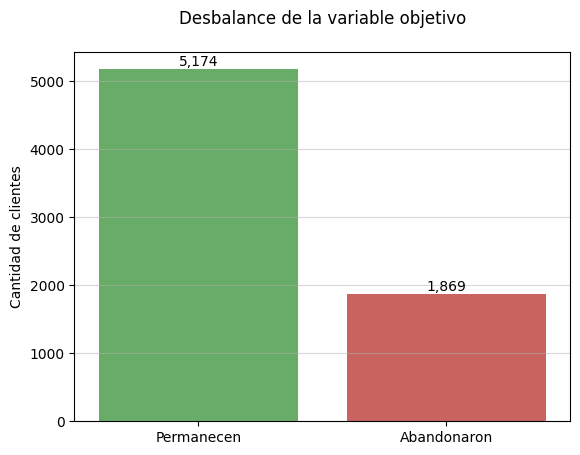

In [22]:
# Conteo de valores en la columna IsChurn
churn_counts = df_contract['IsChurn'].value_counts().sort_index() 

# Definir colores personalizados en el mismo orden que las barras (0: No Churn, 1: Churn)
custom_colors = ['#5CB85C', '#D9534F']

# Visualización de la distribución de la variable IsChurn
ax = sns.barplot(x=churn_counts.index.astype(str), y=churn_counts.values, hue=churn_counts.index.astype(str), palette=custom_colors)

# Etiquetas y título
for i, value in enumerate(churn_counts.values):
    ax.text(i, value + max(churn_counts.values) * 0.001, f'{value:,}', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('Cantidad de clientes')
plt.title('Desbalance de la variable objetivo', pad=20)
plt.xticks([0, 1], ['Permanecen', 'Abandonaron'])
plt.grid(axis='y', alpha=0.5)
plt.show()

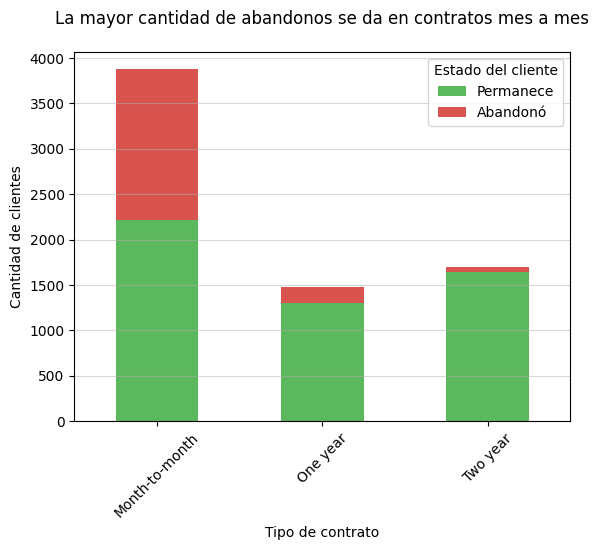

In [23]:
# Agrupar datos por tipo de contrato y churn, y organizarlos
type_vs_churn = df_contract.groupby('Type')['IsChurn'].value_counts().unstack()

# Visualización de la distribución del tipo de contrato en funcion del abandono
type_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
plt.title('La mayor cantidad de abandonos se da en contratos mes a mes', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

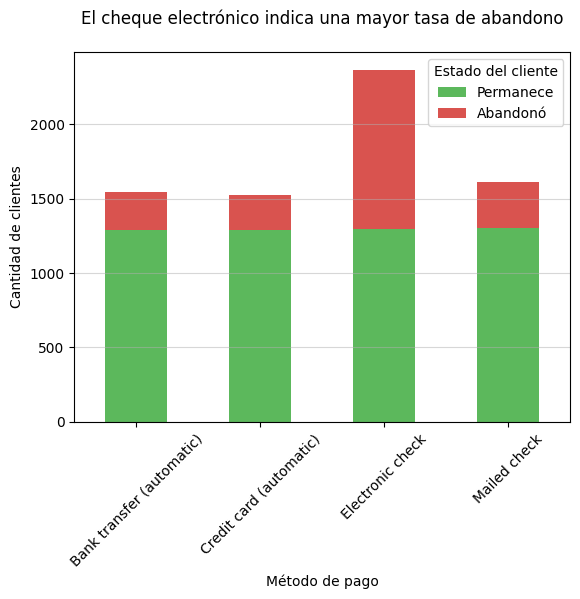

In [24]:
# Agrupar datos por método de pago y churn, y organizarlos
payment_vs_churn = df_contract.groupby('PaymentMethod')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable PaymentMethod en funcion del abandono
payment_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Método de pago')
plt.ylabel('Cantidad de clientes')
plt.title('El cheque electrónico indica una mayor tasa de abandono', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

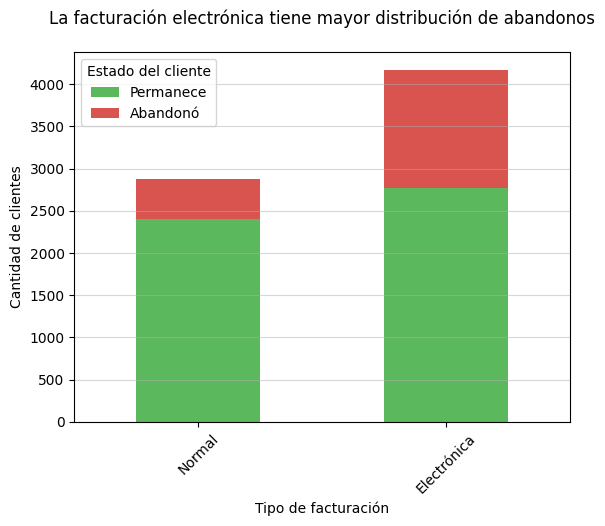

In [25]:
# Agrupar datos por tipo de facturación y churn, y organizarlos
billing_vs_churn = df_contract.groupby('PaperlessBilling')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable PaperlessBilling en funcion del abandono
billing_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Tipo de facturación')
plt.ylabel('Cantidad de clientes')
plt.title('La facturación electrónica tiene mayor distribución de abandonos', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks([0, 1], ['Normal', 'Electrónica'], rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

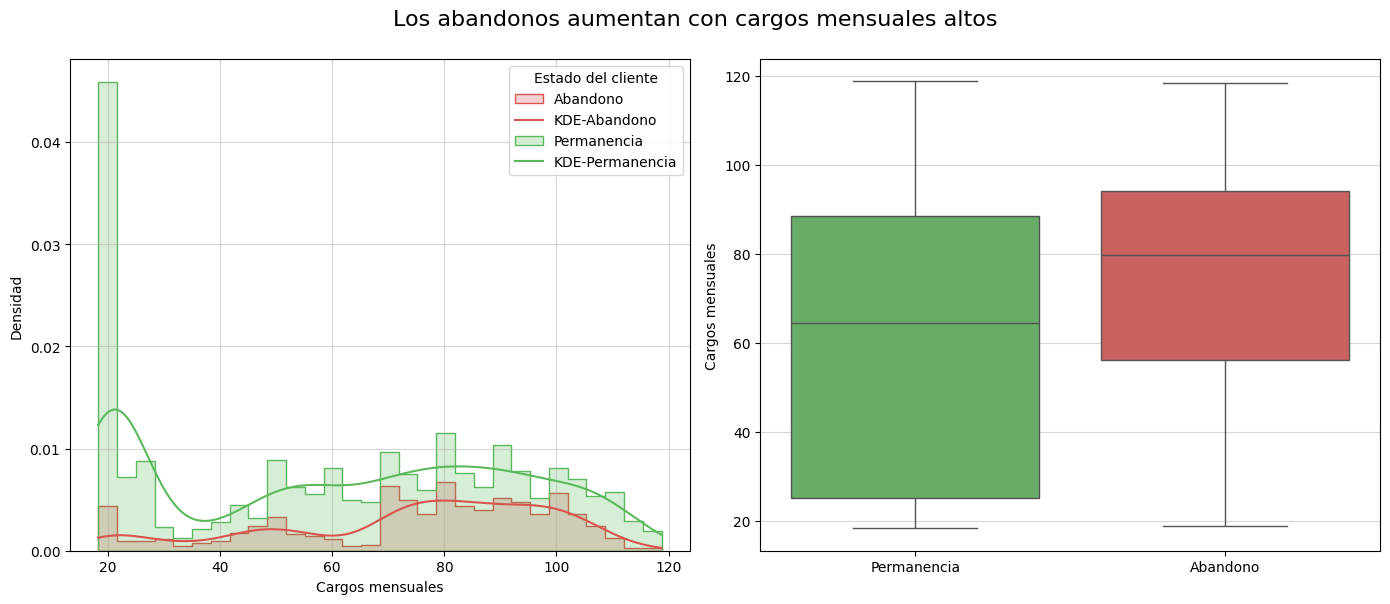

In [26]:
# Visualización de la distribución de los cargos mensuales en funcion del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='MonthlyCharges', hue='IsChurn', bins=30,
    kde=True, palette=custom_colors, ax=axes[0], element='step', stat='density', legend=True
)
axes[0].set_xlabel('Cargos mensuales')
axes[0].set_ylabel('Densidad')
axes[0].legend(title='Estado del cliente', labels=['Abandono', 'KDE-Abandono', 'Permanencia', 'KDE-Permanencia'])
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='IsChurn', y='MonthlyCharges', hue='IsChurn', palette=custom_colors, ax=axes[1], legend=False
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Cargos mensuales')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Permanencia', 'Abandono'])

axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Los abandonos aumentan con cargos mensuales altos', fontsize=16, y=1)
plt.tight_layout()
plt.show()

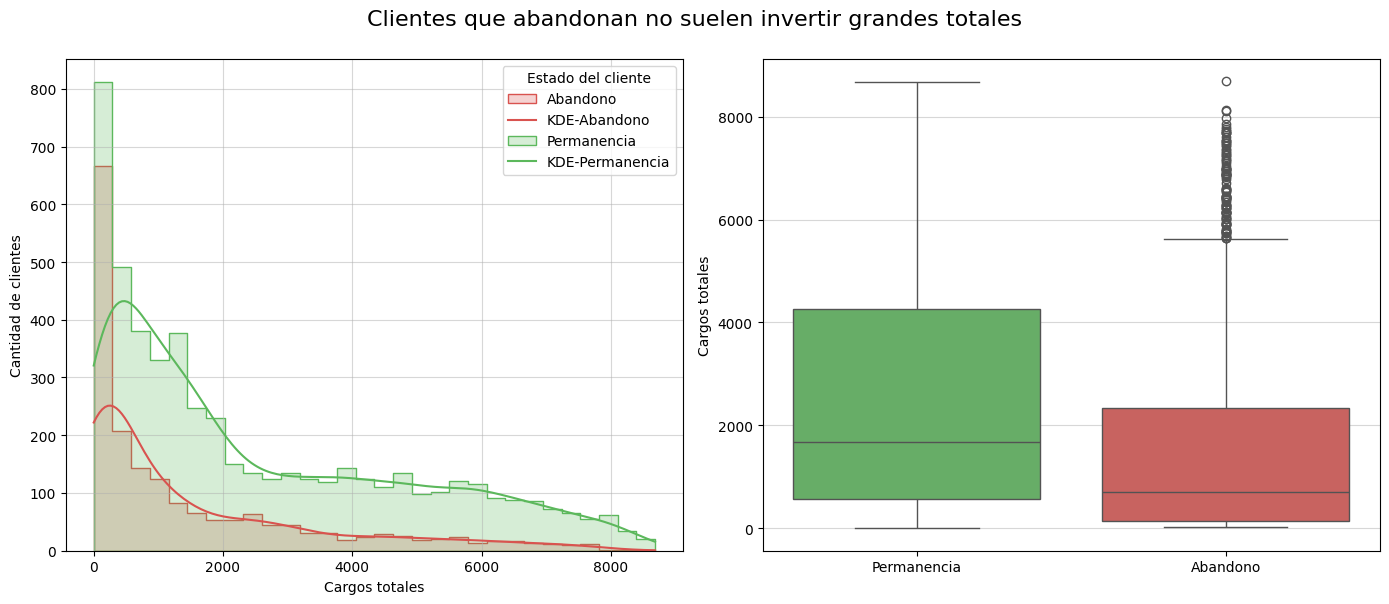

In [27]:
# Visualización de la distribución de los cargos totales en funcion del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='TotalCharges', hue='IsChurn', bins=30,
    kde=True, palette=custom_colors, ax=axes[0], element='step'
)
axes[0].set_xlabel('Cargos totales')
axes[0].set_ylabel('Cantidad de clientes')
axes[0].legend(title='Estado del cliente', labels=['Abandono', 'KDE-Abandono', 'Permanencia', 'KDE-Permanencia'])
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='IsChurn', y='TotalCharges', hue='IsChurn', palette=custom_colors, ax=axes[1], legend=False
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Cargos totales')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Permanencia', 'Abandono'])

axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Clientes que abandonan no suelen invertir grandes totales', fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [28]:
# Calcula la duración en meses antes del abandono
def diff_months(row):
	if pd.notnull(row['EndDate']) and pd.notnull(row['BeginDate']):
		end = row['EndDate']
		begin = row['BeginDate']
		return (end.year - begin.year) * 12 + (end.month - begin.month)
	else:
		return np.nan

# Aplica la función para calcular la duración en meses
df_contract['DurationMonths'] = df_contract.apply(diff_months, axis=1)
df_contract['DurationMonths'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: DurationMonths, dtype: float64

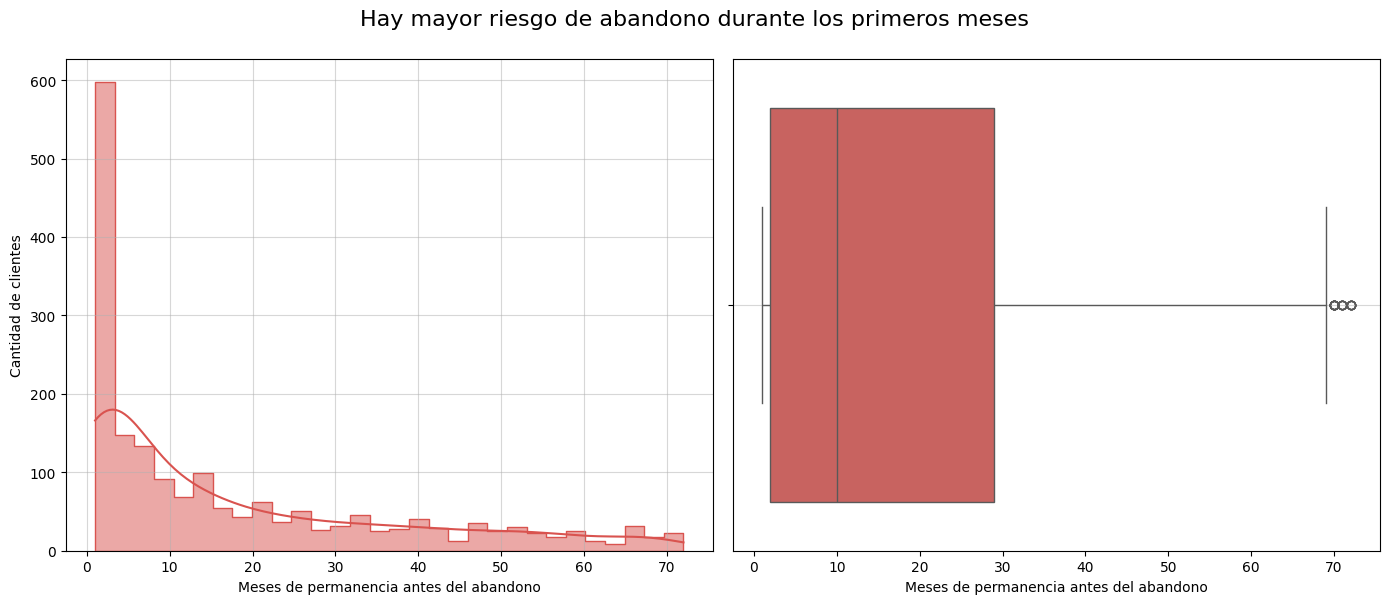

In [29]:
# Visualización de la duración de clientes en meses antes del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='DurationMonths', color=custom_colors[1], bins=30,
    kde=True, ax=axes[0], element='step', legend=True
)
axes[0].set_xlabel('Meses de permanencia antes del abandono')
axes[0].set_ylabel('Cantidad de clientes')
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='DurationMonths', color=custom_colors[1], ax=axes[1], legend=False, orient='horizontal'
)
axes[1].set_ylabel('')
axes[1].set_xlabel('Meses de permanencia antes del abandono')
axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Hay mayor riesgo de abandono durante los primeros meses', fontsize=16, y=1)
plt.tight_layout()
plt.show()

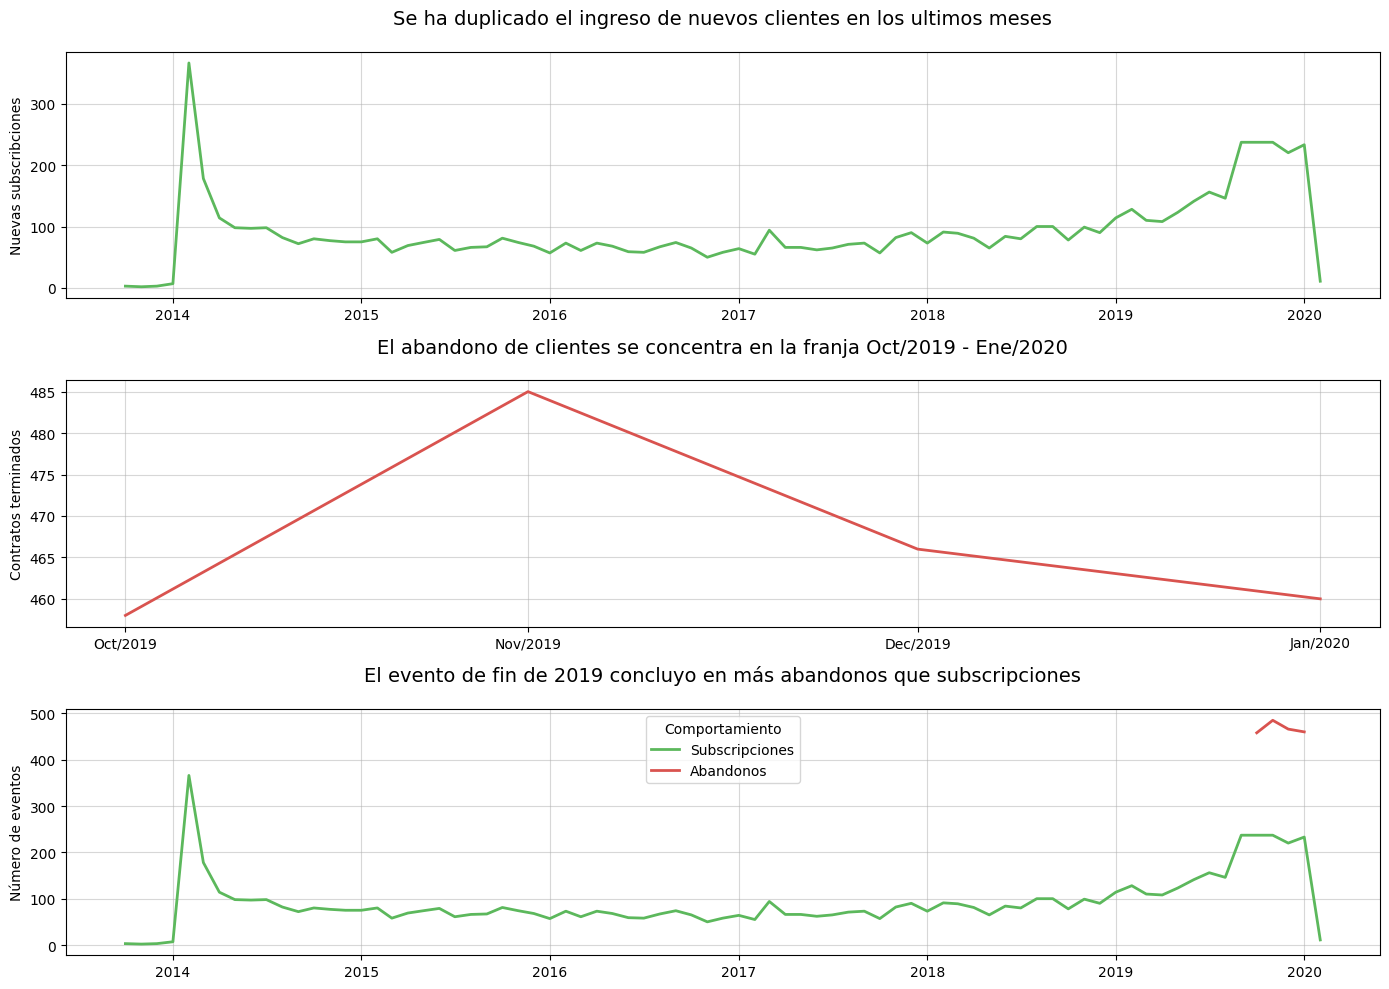

In [30]:
import matplotlib.dates as mdates

# Visualización de la evolución en el abandono y subscripción de clientes mensual.
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Diagrama de lineas de la evolución de la llegada de clientes mensual
sns.lineplot(
    data=df_contract['BeginDate'].value_counts().sort_index(), color=custom_colors[0], ax=axes[0],  linewidth=2
)
axes[0].set_title('Se ha duplicado el ingreso de nuevos clientes en los ultimos meses', fontsize=14, pad=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('Nuevas subscribciones')
axes[0].grid(axis='both', alpha=0.5)

# Diagrama de lineas de la evolución del abandono mensual
sns.lineplot(
    data=df_contract['EndDate'].value_counts(), color=custom_colors[1], ax=axes[1], linewidth=2
)
axes[1].set_title('El abandono de clientes se concentra en la franja Oct/2019 - Ene/2020', fontsize=14, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Contratos terminados')
axes[1].grid(axis='both', alpha=0.5)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Compilación de las subscripciones y abandonos
sns.lineplot(
    data=df_contract['BeginDate'].value_counts().sort_index(), color=custom_colors[0], ax=axes[2],  linewidth=2, label='Subscripciones'
)
sns.lineplot(
    data=df_contract['EndDate'].value_counts(), color=custom_colors[1], ax=axes[2], linewidth=2, label='Abandonos'
)
axes[2].set_title('El evento de fin de 2019 concluyo en más abandonos que subscripciones', fontsize=14, pad=20)
axes[2].set_xlabel('')
axes[2].set_ylabel('Número de eventos')
axes[2].grid(axis='both', alpha=0.5)
axes[2].legend(title='Comportamiento')

plt.tight_layout()
plt.show()


In [31]:
# Flujo de clientes mensualmente y clientes totales
clients_flow = pd.DataFrame(df_contract['BeginDate'].value_counts().sort_index())
clients_flow = clients_flow.merge(df_contract['EndDate'].value_counts(), how='left', left_index=True, right_index=True, suffixes= ['_subscribe', '_churn'])
clients_flow['count_churn'] = clients_flow['count_churn'].fillna(0)
clients_flow['total_clients'] = clients_flow['count_subscribe'].cumsum() - clients_flow['count_churn'].cumsum()
clients_flow.tail(6)

,count_subscribe,count_churn,total_clients
BeginDate,,,
2019-09-01,237,0.0,6105.0
2019-10-01,237,458.0,5884.0
2019-11-01,237,485.0,5636.0
2019-12-01,220,466.0,5390.0
2020-01-01,233,460.0,5163.0
2020-02-01,11,0.0,5174.0


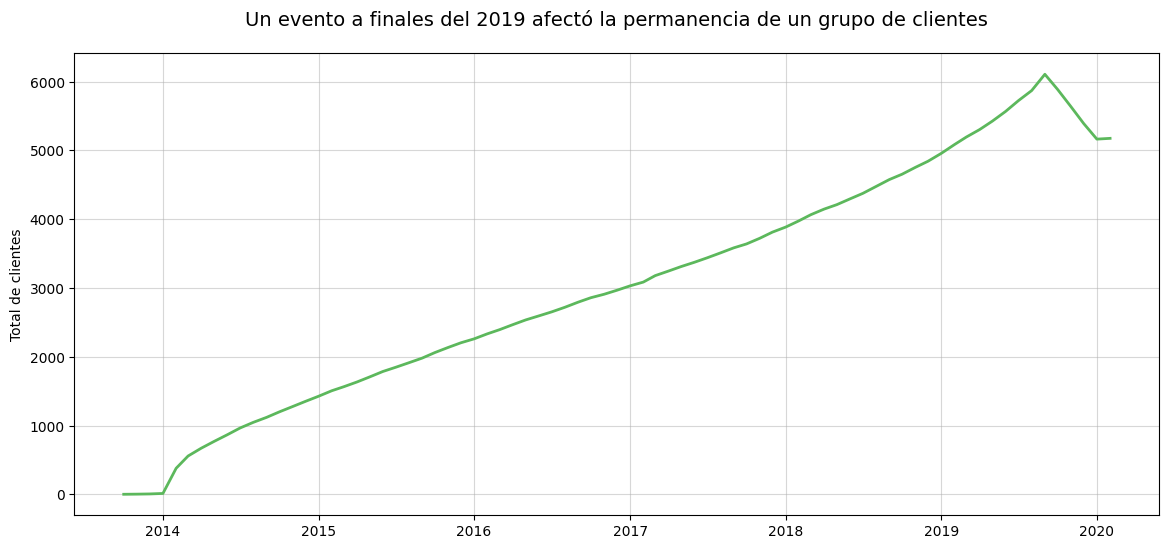

In [32]:
# Visualización del crecimiento del negocio en función del número de clientes
fig, axes = plt.subplots(figsize=(14, 6))

# Histograma en el segundo subplot
sns.lineplot(
    data=clients_flow, x=clients_flow.index, y='total_clients', color=custom_colors[0], linewidth=2
)

axes.set_title('Un evento a finales del 2019 afectó la permanencia de un grupo de clientes', fontsize=14, pad=20)
axes.set_xlabel('')
axes.set_ylabel('Total de clientes')
axes.grid(axis='both', alpha=0.5)

plt.show()

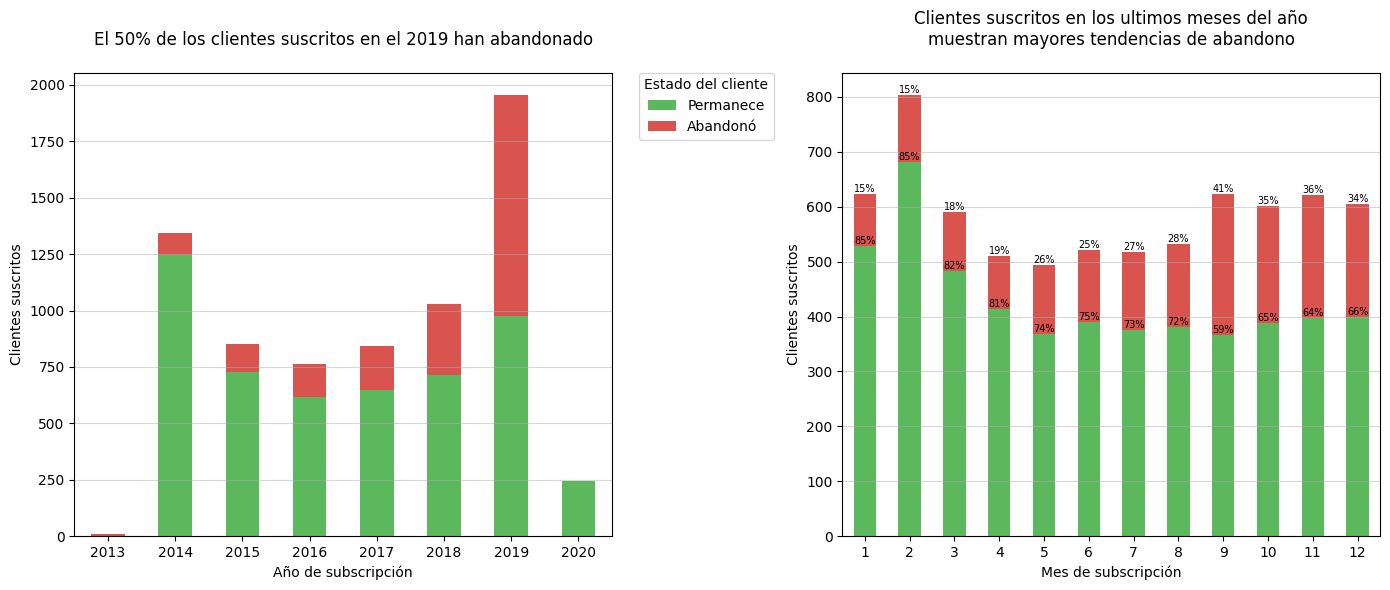

In [33]:
# Extraemos el año y mes de la fecha de subscripción
df_contract['BeginYear'] = [x.year for x in df_contract['BeginDate']]
df_contract['BeginMonth'] = [x.month for x in df_contract['BeginDate']]

# Agrupar datos por año y mes de subscripción y churn, y organizarlos
year_vs_churn = df_contract.groupby('BeginYear')['IsChurn'].value_counts().unstack()
month_vs_churn = df_contract.groupby('BeginMonth')['IsChurn'].value_counts().unstack()
month_vs_churn_percentage = df_contract.groupby('BeginMonth')['IsChurn'].value_counts(normalize=True).unstack().round(2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Visualización de la distribución de la variable BeginYear en funcion del abandono
year_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[0], rot=0)

# Etiquetas y título
axes[0].set_xlabel('Año de subscripción')
axes[0].set_ylabel('Clientes suscritos')
axes[0].set_title('El 50% de los clientes suscritos en el 2019 han abandonado', pad=20)
axes[0].legend(
    title='Estado del cliente', 
    labels=['Permanece', 'Abandonó'], 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    borderaxespad=0.
)
axes[0].grid(axis='y', alpha=0.5)

# Visualización de la distribución de la variable BeginMonth en funcion del abandono
month_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[1], rot=0, legend=False)

# Etiquetas y título
for i, array in enumerate(month_vs_churn.values):
    for j, value in enumerate(array):
        axes[1].text(i, np.cumsum(array)[j], f'{100*month_vs_churn_percentage.values[i, j]:.0f}%', ha='center', va='bottom', fontsize=7)
    
axes[1].set_xlabel('Mes de subscripción')
axes[1].set_ylabel('Clientes suscritos')
axes[1].set_title('Clientes suscritos en los ultimos meses del año\nmuestran mayores tendencias de abandono', pad=20)
axes[1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

- Se requerirá de aplicar técnicas de balanceo de clases para entrenar a los modelos.
- Los usuarios que hacen pagos mes a mes, realizan pagos con cheque electrónico, y usan facturación electrónica, tienden a abandonar más que otros usuarios.
- La distribución de los usuarios que abandonaron tiene tendencias centrales en cargos mensuales más elevados, también la tendencia central de cargos totales es menor, indicando que usualmente quienes abandonan lo hacen con prontitud. Esto se confirma al observar que la mediana de meses de permanencia de los usuarios que abandonaron es de 10 meses.
- El número de subscripciones de nuevos usuarios mensualmente es similar a través de la historia de la compañía (al rededor de 80 contratos por mes), sin embargo, un evento en los últimos meses (octubre/2019 - enero/2020) atrajo a más del doble de usuarios que comúnmente se tenían, pero también indujo una perdida mayor de un grupo usuarios, traduciéndose en un flujo negativo de usuarios en los últimos meses.
- Tendremos en cuenta la columna BeginDate en dos columnas nuevas para la entrada de los modelos: BeginYear y BeginMonth, las cuales proporcionarán información relevante en las tendencias de abandono, sin embargo, la columna EndDate y cualquier columna derivada de esta no será incluida ya que implicaría un problema en la fuga de datos.

#### Datos personales

In [34]:
# Combinar los datos de abandono (df_contract) con los personales (df_personal)
df_con_per = df_contract.merge(df_personal, how='inner', left_on='customerID', right_on='customerID', validate='1:1')
df_con_per

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths,BeginYear,BeginMonth,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN,2020,1,Female,0,1,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN,2017,4,Male,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,2019,10,Male,0,0,0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN,2016,5,Male,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0,2019,9,Female,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.50,0,NaN,2018,2,Male,0,1,1
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.90,0,NaN,2014,2,Female,0,1,1
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,346.45,0,NaN,2019,3,Female,0,1,1
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,1,4.0,2019,7,Male,1,1,0


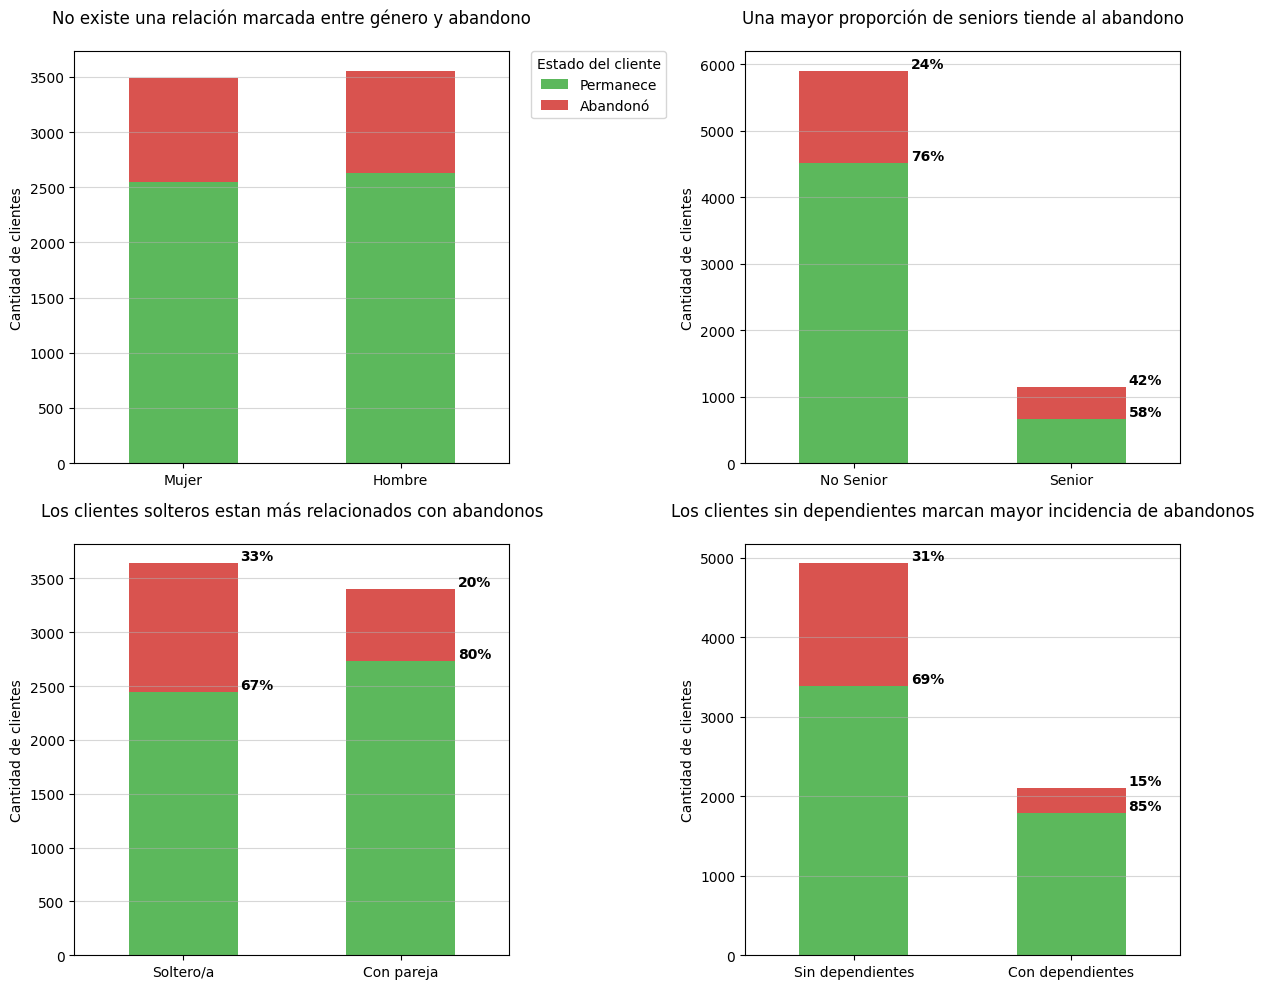

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Agrupar datos por género y churn, y organizarlos
gender_vs_churn = df_con_per.groupby('gender')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable gender en funcion del abandono
gender_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[0, 0])

# Etiquetas y título
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Cantidad de clientes')
axes[0, 0].set_title('No existe una relación marcada entre género y abandono', pad=20)
axes[0, 0].legend(
    title='Estado del cliente', 
    labels=['Permanece', 'Abandonó'], 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    borderaxespad=0.
)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Mujer', 'Hombre'], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.5)

# Agrupar datos por seniority y churn, y organizarlos
senior_vs_churn = df_con_per.groupby('SeniorCitizen')['IsChurn'].value_counts().unstack()
senior_vs_churn_percentage = df_con_per.groupby('SeniorCitizen')['IsChurn'].value_counts(normalize=True).unstack().round(2)

# Visualización de la distribución de la variable seniority en funcion del abandono
senior_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[0, 1], legend=False)

# Etiquetas y título
for i, array in enumerate(senior_vs_churn.values):
    for j, value in enumerate(array):
        axes[0, 1].text(i + 0.34, np.cumsum(array)[j], f'{100*senior_vs_churn_percentage.values[i, j]:.0f}%', ha='center', va='bottom', weight='bold')
    
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('Cantidad de clientes')
axes[0, 1].set_title('Una mayor proporción de seniors tiende al abandono', pad=20)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['No Senior', 'Senior'], rotation=0)
axes[0, 1].grid(axis='y', alpha=0.5)

# Agrupar datos por partner y churn, y organizarlos
partner_vs_churn = df_con_per.groupby('Partner')['IsChurn'].value_counts().unstack()
partner_vs_churn_percentage = df_con_per.groupby('Partner')['IsChurn'].value_counts(normalize=True).unstack()

# Visualización de la distribución de la variable partner en funcion del abandono
partner_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[1, 0], legend=False)

# Etiquetas y título
for i, array in enumerate(partner_vs_churn.values):
    for j, value in enumerate(array):
        axes[1, 0].text(i + 0.34, np.cumsum(array)[j], f'{100*partner_vs_churn_percentage.values[i, j]:.0f}%', ha='center', va='bottom', weight='bold')
    
axes[1, 0].set_xlabel('')
axes[1, 0].set_ylabel('Cantidad de clientes')
axes[1, 0].set_title('Los clientes solteros estan más relacionados con abandonos', pad=20)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Soltero/a', 'Con pareja'], rotation=0)
axes[1, 0].grid(axis='y', alpha=0.5)

# Agrupar datos por dependientes y churn, y organizarlos
dependents_vs_churn = df_con_per.groupby('Dependents')['IsChurn'].value_counts().unstack()
dependents_vs_churn_percentage = df_con_per.groupby('Dependents')['IsChurn'].value_counts(normalize=True).unstack().round(2)

# Visualización de la distribución de la variable dependents en funcion del abandono
dependents_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[1, 1], legend=False)

# Etiquetas y título
for i, array in enumerate(dependents_vs_churn.values):
    for j, value in enumerate(array):
        axes[1, 1].text(i + 0.34, np.cumsum(array)[j], f'{100*dependents_vs_churn_percentage.values[i, j]:.0f}%', ha='center', va='bottom', weight='bold')
    
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Cantidad de clientes')
axes[1, 1].set_title('Los clientes sin dependientes marcan mayor incidencia de abandonos', pad=20)
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Sin dependientes', 'Con dependientes'], rotation=0)
axes[1, 1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

- El género no marca una diferencia apreciable en los abandonos, esta característica podría ser ignorada como entrada de los modelos.
- El estado civil, el seniority y si el usuario tiene dependientes a su cargo esta medianamente relacionado con algunas tendencias en el abandono, por lo que en conjunto pueden ser utiles para los modelos.

#### Datos de internet

In [36]:
# Combinar los datos de abandono (df_contract) con los personales (df_personal)
df_con_int = df_contract.merge(df_internet, how='left', left_on='customerID', right_on='customerID')
df_con_int.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths,BeginYear,BeginMonth,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN,2020,1,DSL,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN,2017,4,DSL,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,2019,10,DSL,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN,2016,5,DSL,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0,2019,9,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0


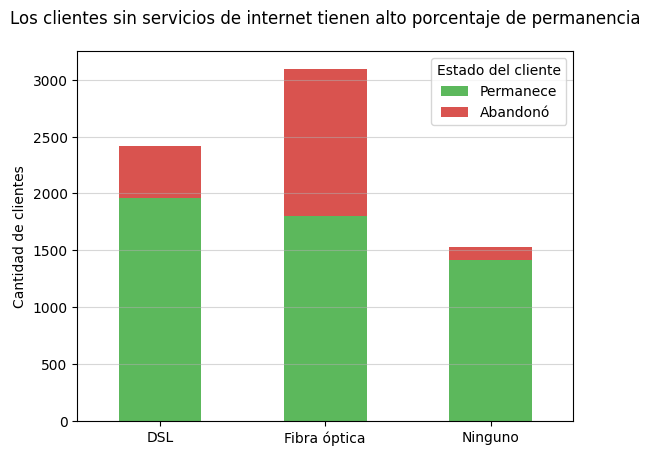

In [37]:
# Agrupar datos por servicio de internet y churn, y organizarlos
internet_vs_churn = df_con_int.groupby('InternetService', dropna=False)['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable InternetService en funcion del abandono
internet_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('')
plt.ylabel('Cantidad de clientes')
plt.title('Los clientes sin servicios de internet tienen alto porcentaje de permanencia', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks([0, 1, 2], ['DSL', 'Fibra óptica', 'Ninguno'], rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

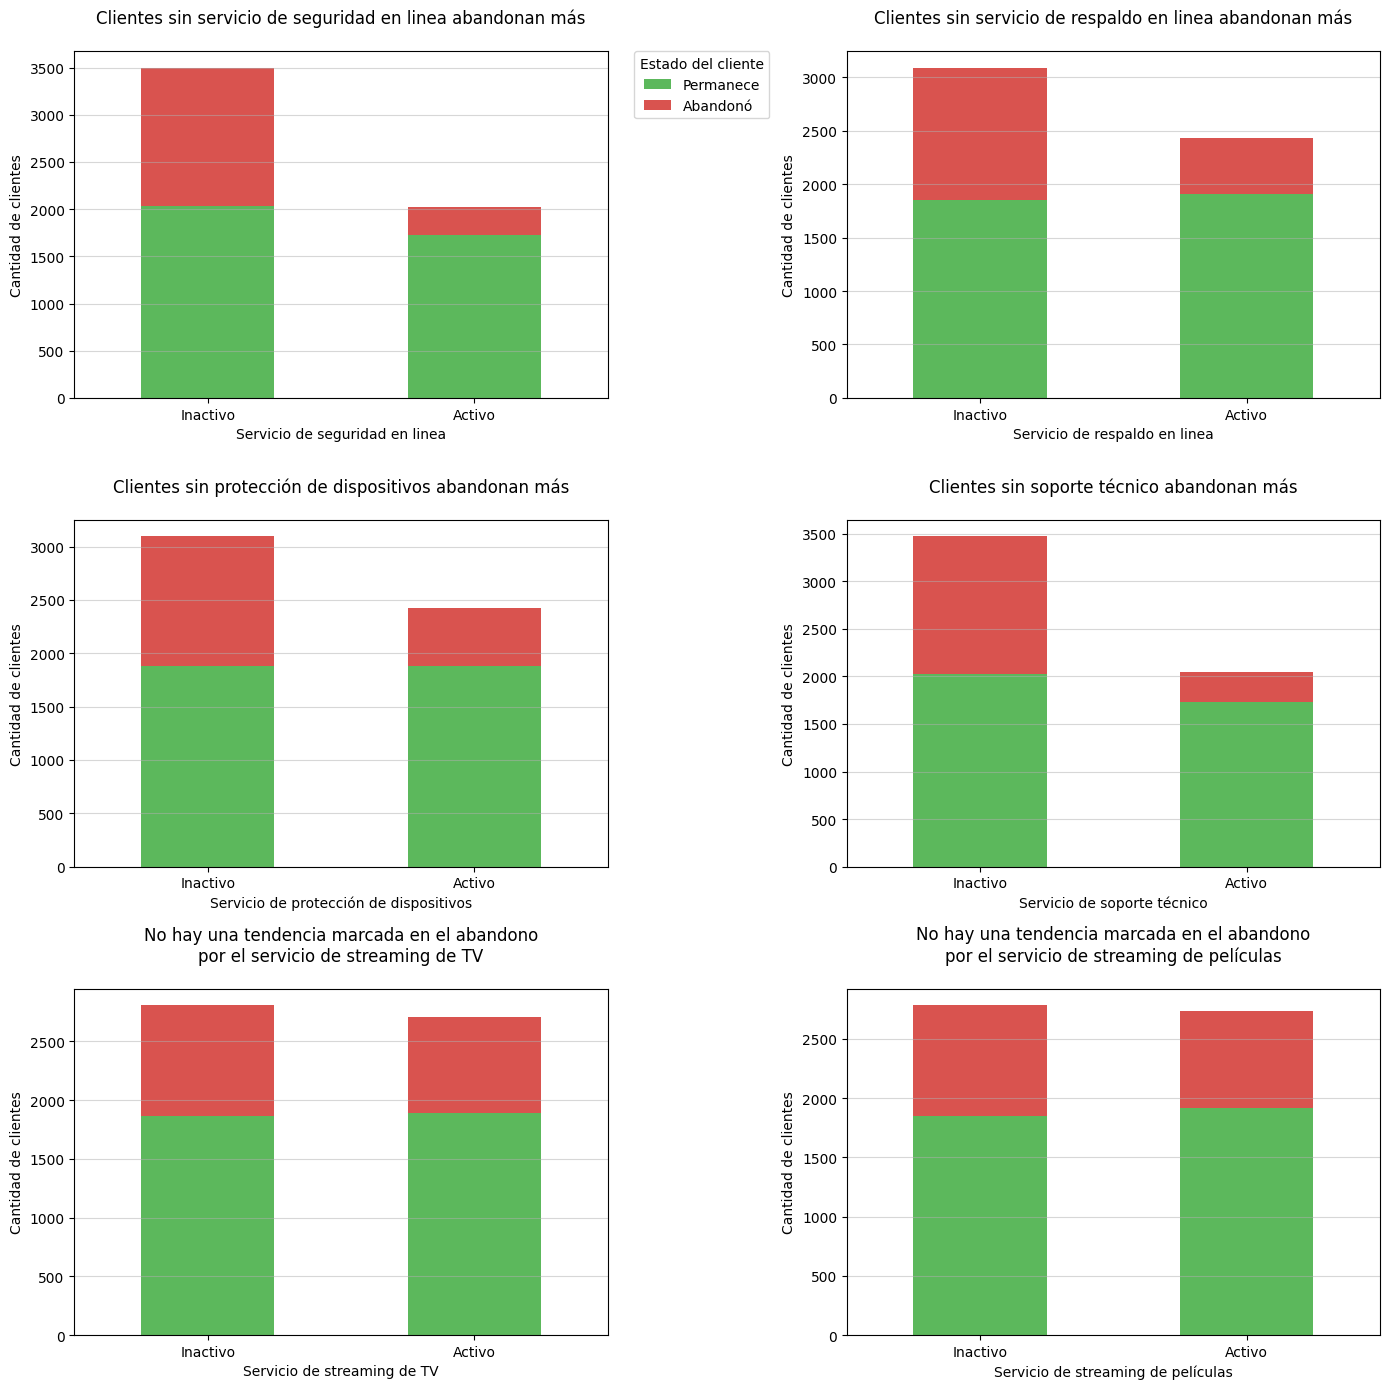

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# Agrupar datos por servicios de seguridad y churn, y organizarlos
security_vs_churn = df_con_int.groupby('OnlineSecurity')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable OnlineSecurity en funcion del abandono
security_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[0, 0])

# Etiquetas y título
axes[0, 0].set_xlabel('Servicio de seguridad en linea')
axes[0, 0].set_ylabel('Cantidad de clientes')
axes[0, 0].set_title('Clientes sin servicio de seguridad en linea abandonan más', pad=20)
axes[0, 0].legend(
    title='Estado del cliente', 
    labels=['Permanece', 'Abandonó'], 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    borderaxespad=0.
)
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[0, 0].grid(axis='y', alpha=0.5)

# Agrupar datos por respaldo en linea y churn, y organizarlos
backup_vs_churn = df_con_int.groupby('OnlineBackup')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable OnlineBackup en funcion del abandono
backup_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[0, 1], legend=False)

# Etiquetas y título
axes[0, 1].set_xlabel('Servicio de respaldo en linea')
axes[0, 1].set_ylabel('Cantidad de clientes')
axes[0, 1].set_title('Clientes sin servicio de respaldo en linea abandonan más', pad=20)
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[0, 1].grid(axis='y', alpha=0.5)

# Agrupar datos por protección de dispositivo y churn, y organizarlos
device_vs_churn = df_con_int.groupby('DeviceProtection')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable DeviceProtection en funcion del abandono
device_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[1, 0], legend=False)

# Etiquetas y título
axes[1, 0].set_xlabel('Servicio de protección de dispositivos')
axes[1, 0].set_ylabel('Cantidad de clientes')
axes[1, 0].set_title('Clientes sin protección de dispositivos abandonan más', pad=20)
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[1, 0].grid(axis='y', alpha=0.5)

# Agrupar datos por soporte técnico y churn, y organizarlos
support_vs_churn = df_con_int.groupby('TechSupport')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable TechSupport en funcion del abandono
support_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[1, 1], legend=False)

# Etiquetas y título
axes[1, 1].set_xlabel('Servicio de soporte técnico')
axes[1, 1].set_ylabel('Cantidad de clientes')
axes[1, 1].set_title('Clientes sin soporte técnico abandonan más', pad=20)
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[1, 1].grid(axis='y', alpha=0.5)

# Agrupar datos por streaming y churn, y organizarlos
tv_vs_churn = df_con_int.groupby('StreamingTV')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable StreamingTV en funcion del abandono
tv_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[2, 0], legend=False)

# Etiquetas y título
axes[2, 0].set_xlabel('Servicio de streaming de TV')
axes[2, 0].set_ylabel('Cantidad de clientes')
axes[2, 0].set_title('No hay una tendencia marcada en el abandono\npor el servicio de streaming de TV', pad=20)
axes[2, 0].set_xticks([0, 1])
axes[2, 0].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[2, 0].grid(axis='y', alpha=0.5)

# Agrupar datos por streaming de peliculas y churn, y organizarlos
movies_vs_churn = df_con_int.groupby('StreamingMovies')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable StreamingMovies en funcion del abandono
movies_vs_churn.plot(kind='bar', stacked=True, color=custom_colors, ax=axes[2, 1], legend=False)

# Etiquetas y título
axes[2, 1].set_xlabel('Servicio de streaming de películas')
axes[2, 1].set_ylabel('Cantidad de clientes')
axes[2, 1].set_title('No hay una tendencia marcada en el abandono\npor el servicio de streaming de películas', pad=20)
axes[2, 1].set_xticks([0, 1])
axes[2, 1].set_xticklabels(['Inactivo', 'Activo'], rotation=0)
axes[2, 1].grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [39]:
# Resumir la columna InternetService en una nueva columna booleana HasInternet 
df_con_int['HasInternet'] = [1 if pd.notnull(x) else 0 for x in df_con_int['InternetService']]

# Crear una nueva columna que cuente la cantidad de servicios activos por cliente
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'HasInternet']
df_con_int['ServicesCount'] = df_con_int[service_columns].sum(axis=1).astype(int)
df_con_int.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths,...,BeginMonth,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,HasInternet,ServicesCount
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN,...,1,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1,2
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN,...,4,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1,3
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,...,10,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1,3
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN,...,5,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1,4
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0,...,9,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1,1


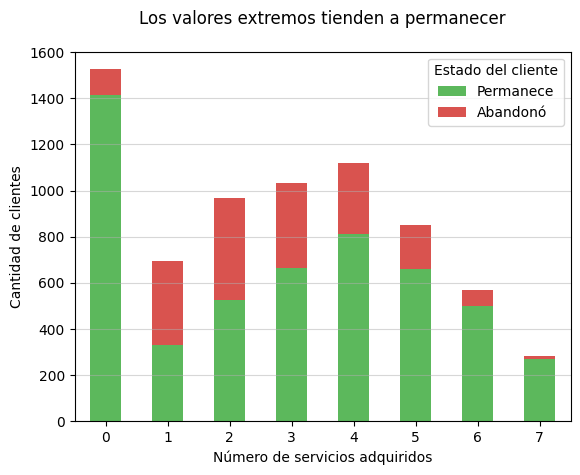

In [40]:
# Agrupar datos por cantidad de servicios y churn, y organizarlos
anyservice_vs_churn = df_con_int.groupby('ServicesCount')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable ServicesCount en funcion del abandono
anyservice_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Número de servicios adquiridos')
plt.ylabel('Cantidad de clientes')
plt.title('Los valores extremos tienden a permanecer', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks( rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

- Los usuarios presentan comportamientos diferenciados según el tipo de conexión a internet que utilizan o si no cuentan con servicio de internet. Esta variable podría ser útil al transformarla en una columna ordinal con etiquetas.
- Los servicios de streaming, considerados individualmente, no aportan un valor significativo para predecir el abandono de clientes, por lo que se eliminarán como variables independientes en los modelos. No obstante, la suma total de servicios contratados por cada usuario sí revela un patrón relevante, por lo que se mantendrá esta información agregada, incorporando indirectamente parte de las variables eliminadas.

#### Datos telefónicos

In [41]:
df_con_int_pho = df_con_int.merge(df_phone, how='left', on='customerID')
df_con_int_pho

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,HasInternet,ServicesCount,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN,...,DSL,0.0,1.0,0.0,0.0,0.0,0.0,1,2,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN,...,DSL,1.0,0.0,1.0,0.0,0.0,0.0,1,3,0.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,...,DSL,1.0,1.0,0.0,0.0,0.0,0.0,1,3,0.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN,...,DSL,1.0,0.0,1.0,1.0,0.0,0.0,1,4,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.50,0,NaN,...,DSL,1.0,0.0,1.0,1.0,1.0,1.0,1,6,1.0
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.90,0,NaN,...,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,1,5,1.0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,346.45,0,NaN,...,DSL,1.0,0.0,0.0,0.0,0.0,0.0,1,2,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,1,4.0,...,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0


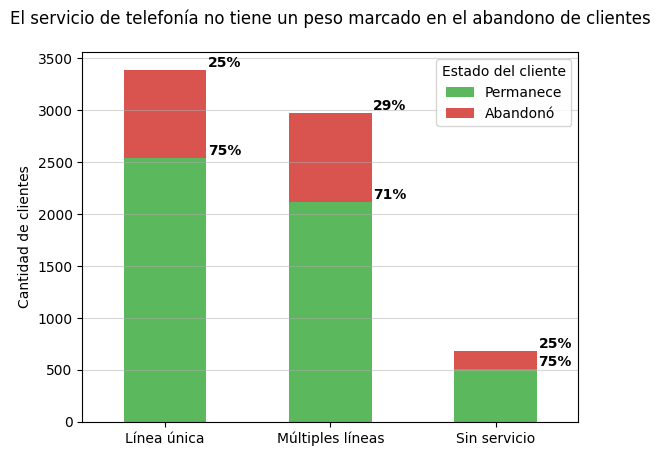

In [42]:
# Agrupar datos por lineas de telefonia y churn, y organizarlos
phone_vs_churn = df_con_int_pho.groupby('MultipleLines', dropna=False)['IsChurn'].value_counts().unstack()
phone_vs_churn_percentage = df_con_int_pho.groupby('MultipleLines', dropna=False)['IsChurn'].value_counts(normalize=True).unstack().round(2)

# Visualización de la distribución de la variable MultipleLines en funcion del abandono
ax = phone_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
for i, array in enumerate(phone_vs_churn.values):
    for j, value in enumerate(array):
        ax.text(i + 0.36, np.cumsum(array)[j], f'{100*phone_vs_churn_percentage.values[i, j]:.0f}%', ha='center', va='bottom', weight='bold')
    
plt.xlabel('')
plt.ylabel('Cantidad de clientes')
plt.title('El servicio de telefonía no tiene un peso marcado en el abandono de clientes', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks([0, 1, 2], ['Línea única', 'Múltiples líneas', 'Sin servicio'], rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

In [43]:
# Resumir la columna MultipleLines en una nueva columna booleana HasPhone 
df_con_int_pho['HasPhone'] = [1 if pd.notnull(x) else 0 for x in df_con_int_pho['MultipleLines']]

# Crear una nueva columna que cuente la cantidad de servicios activos por cliente
all_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'HasInternet', 'HasPhone']
df_con_int_pho['AllServicesCount'] = df_con_int_pho[all_service_columns].sum(axis=1).astype(int)
df_con_int_pho.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,HasInternet,ServicesCount,MultipleLines,HasPhone,AllServicesCount
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN,...,1.0,0.0,0.0,0.0,0.0,1,2,NaN,0,2
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN,...,0.0,1.0,0.0,0.0,0.0,1,3,0.0,1,4
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0,...,1.0,0.0,0.0,0.0,0.0,1,3,0.0,1,4
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN,...,0.0,1.0,1.0,0.0,0.0,1,4,NaN,0,4
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,1,2


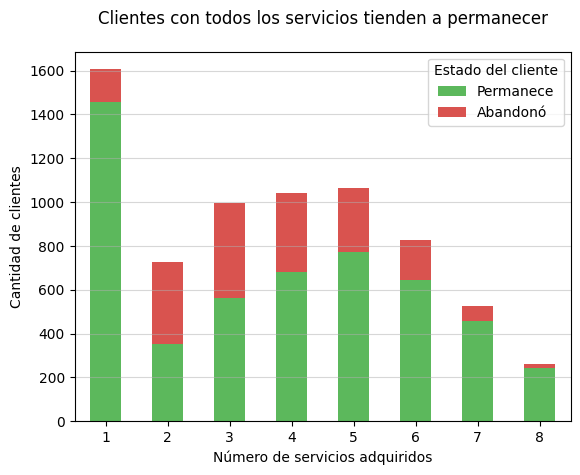

In [44]:
# Agrupar datos por cantidad de servicios y churn, y organizarlos
allservice_vs_churn = df_con_int_pho.groupby('AllServicesCount')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable ServicesCount en funcion del abandono
allservice_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Número de servicios adquiridos')
plt.ylabel('Cantidad de clientes')
plt.title('Clientes con todos los servicios tienden a permanecer', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks( rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.show()

- El uso de múltiples líneas telefónicas o del servicio de telefonía no tiene una fuerte influencia en el abandono de los clientes, por lo que esta característica no se tendrá en cuenta como entrada para los modelos.
- El uso de todos los servicios combinados (internet + telefonía) tiene un comportamiento similar al de todos los servicios de internet evaluados, por ende se utilizará esta columna, ya que resume una mayor cantidad de información en una sola entrada.

## 3. Preparación de los datos para los modelos <a id='data_preprocessing'></a> 

### 3.1. Selección de características y objetivos <a id='feature_selection'></a>

Para iniciar, seleccionaremos las características y la columna objetivo, basándonos en las conclusiones de nuestro análisis exploratorio:

Informativas:
- 'customerID': identificación del contrato con el cliente.

Características:
- 'BeginYear': año de subscripción.
- 'BeginMonth': mes de subscripción.
- 'Type': tipo de contrato.
- 'PaperlessBilling': facturación electrónica.
- 'PaymentMethod': método de pago.
- 'MonthlyCharges': cargos mensuales.
- 'TotalCharges': cargos totales.
- 'SeniorCitizen': seniority del cliente.
- 'Partner': estado civil simplificado del cliente.
- 'Dependents': considera si el cliente tiene dependientes a su cargo.
- 'InternetService': considera si tiene contratado servicio de internet y el tipo.
- 'OnlineSecurity': considera si el cliente tiene servicio de seguridad en línea.
- 'OnlineBackup': considera si el cliente tiene servicio de respaldo en línea.
- 'DeviceProtection': considera si en el cliente tiene protección de dispositivos.
- 'TechSupport': considera si el cliente tiene soporte técnico.
- 'AllServicesCount': total de servicios contratados.

Objetivo:
- 'IsChurn': el cliente ha abandonado o no.

In [45]:
# Selección de características y objetivos
data = pd.concat(
    [
        df_contract[[
            'customerID',
            'BeginYear', 
            'BeginMonth',
            'Type',
            'PaperlessBilling',
            'PaymentMethod', 
            'MonthlyCharges', 
            'TotalCharges',
        ]],
        df_personal[[
            'SeniorCitizen',
            'Partner', 
            'Dependents'
        ]],
        df_con_int_pho[[        
            'InternetService', 
            'OnlineSecurity', 
            'OnlineBackup',
            'DeviceProtection', 
            'TechSupport', 
            'AllServicesCount'
        ]],   
        df_contract[[
            'IsChurn'
        ]]
    ], 
    axis=1
)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginYear         7043 non-null   int64  
 2   BeginMonth        7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   int64  
 10  Dependents        7043 non-null   int64  
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   float64
 13  OnlineBackup      5517 non-null   float64
 14  DeviceProtection  5517 non-null   float64
 15  TechSupport       5517 non-null   float64
 16  AllServicesCount  7043 non-null   int64  


Las columnas InternetService, OnlineSecurity, OnlineBackup, DeviceProtection y TechSupport requerirán un preprocesamiento sencillo de sus valores nulos.

In [46]:
# Reemplazamos los nulos de InternetService con 'No'
data['InternetService'] = data['InternetService'].fillna('No')

# Reemplazamos los nulos de los servicios con 0 significando que no se posee el servicio
data['OnlineSecurity'] = data['OnlineSecurity'].fillna(0)
data['OnlineBackup'] = data['OnlineBackup'].fillna(0)
data['DeviceProtection'] = data['DeviceProtection'].fillna(0)
data['TechSupport'] = data['TechSupport'].fillna(0)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginYear         7043 non-null   int64  
 2   BeginMonth        7043 non-null   int64  
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   int64  
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   int64  
 10  Dependents        7043 non-null   int64  
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   float64
 13  OnlineBackup      7043 non-null   float64
 14  DeviceProtection  7043 non-null   float64
 15  TechSupport       7043 non-null   float64
 16  AllServicesCount  7043 non-null   int64  


### 3.2. Balanceo de clases <a id='balance'></a>

Se realizarán dos procesos para balancear la clase IsChurn. Primero se realizará un sobremuestreo de la clase 1 seguido de un submuestreo de la clase 0, el objetivo será mantener la misma cantidad de datos adicionando y retirando a la vez una cantidad equitativa.

In [47]:
# Identificamos las observaciones de clase 1 y clase 0
one_class = data[data['IsChurn'] == 1]
zero_class = data[data['IsChurn'] == 0]

# Contamos la diferencia de cantidades entre una clase y otra
difference = zero_class['IsChurn'].count() - one_class['IsChurn'].count()

# Aplicamos sobremuestreo con reemplazo de la clase 1 aumentando la mitad de la diferencia
new_ones = one_class.sample(difference//2, replace=True, random_state=12345)
new_ones

# Aplicamos submuestreo de la clase 0 reduciendo la mitad de la diferencia
new_zeros = zero_class.sample(len(zero_class)-(difference//2), replace=False, random_state=12345)

data = pd.concat([one_class, new_ones, new_zeros])
data = data.sample(frac=1, replace=False, random_state=12345, ignore_index=True)
data

,customerID,BeginYear,BeginMonth,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,AllServicesCount,IsChurn
0,2114-MGINA,2018,9,Month-to-month,1,Mailed check,89.80,1129.10,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,4,1
1,9986-BONCE,2019,8,Month-to-month,0,Bank transfer (automatic),20.95,85.50,0,0,0,No,0.0,0.0,0.0,0.0,1,1
2,5294-CDGWY,2015,9,One year,0,Electronic check,59.30,3014.65,0,1,1,DSL,1.0,1.0,1.0,0.0,6,1
3,0899-LIIBW,2017,4,Month-to-month,0,Electronic check,100.85,3527.30,0,1,0,Fiber optic,0.0,0.0,1.0,0.0,5,0
4,1698-XFZCI,2015,1,One year,1,Electronic check,107.75,6521.90,0,0,0,Fiber optic,1.0,1.0,1.0,0.0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1260-TTRXI,2019,8,Month-to-month,0,Electronic check,54.30,195.30,0,0,0,DSL,0.0,0.0,0.0,0.0,3,1
7039,2108-XWMPY,2019,7,Month-to-month,1,Mailed check,35.45,106.85,0,0,0,DSL,1.0,1.0,0.0,0.0,3,1
7040,0939-YAPAF,2016,12,Month-to-month,1,Electronic check,100.25,3527.60,0,0,0,Fiber optic,0.0,0.0,1.0,0.0,5,1
7041,2958-NHPPS,2018,3,Month-to-month,0,Electronic check,20.85,473.90,0,0,0,No,0.0,0.0,0.0,0.0,1,0


### 3.3. Codificación y estandarización de características <a id='codification'></a>

Realizaremos los siguientes ajustes para mejorar la entrada y lectura de datos en los modelos:
- Estandarización de las columnas BeginYear, BeginMonth, MonthlyCharges, TotalCharges, AllServicesCount.
- Codificación con etiquetas ordinales a Type, PaymentMethod e InternetService en un dataframe para la regresión logística.
- Codificación con OHE de las mismas columnas previas para los modelos basados en árboles.

In [48]:
# Estandarización de características
columns_to_standarize = ['BeginYear', 'BeginMonth', 'MonthlyCharges', 'TotalCharges', 'AllServicesCount']

# Instanciar y entrenar el estandarizador
scaler = StandardScaler()
scaler.fit(data[columns_to_standarize])

# Estandarizamos las columnas
data[columns_to_standarize] = scaler.transform(data[columns_to_standarize])
data.head()

,customerID,BeginYear,BeginMonth,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,AllServicesCount,IsChurn
0,2114-MGINA,0.436891,0.628891,Month-to-month,1,Mailed check,0.759734,-0.424950,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.157155,1
1,9986-BONCE,0.963148,0.346591,Month-to-month,0,Bank transfer (automatic),-1.628771,-0.902337,0,0,0,No,0.0,0.0,0.0,0.0,-1.370227,1
2,5294-CDGWY,-1.141880,0.628891,One year,0,Electronic check,-0.298354,0.437581,0,1,1,DSL,1.0,1.0,1.0,0.0,1.175410,1
3,0899-LIIBW,-0.089366,-0.782606,Month-to-month,0,Electronic check,1.143075,0.672089,0,1,0,Fiber optic,0.0,0.0,1.0,0.0,0.666283,0
4,1698-XFZCI,-1.141880,-1.629504,One year,1,Electronic check,1.382445,2.041946,0,0,0,Fiber optic,1.0,1.0,1.0,0.0,1.684537,0


In [49]:
# Columnas a transformar con codificación
columns_to_code = ['Type', 'PaymentMethod', 'InternetService']

# Creación de dataframe con caractirizticas Ordinales
data_ordinal = data.copy()

encoder = OrdinalEncoder()
data_ordinal[columns_to_code] = encoder.fit_transform(data_ordinal[columns_to_code])
data_ordinal.head()

,customerID,BeginYear,BeginMonth,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,AllServicesCount,IsChurn
0,2114-MGINA,0.436891,0.628891,0.0,1,3.0,0.759734,-0.424950,0,0,0,1.0,0.0,0.0,0.0,0.0,0.157155,1
1,9986-BONCE,0.963148,0.346591,0.0,0,0.0,-1.628771,-0.902337,0,0,0,2.0,0.0,0.0,0.0,0.0,-1.370227,1
2,5294-CDGWY,-1.141880,0.628891,1.0,0,2.0,-0.298354,0.437581,0,1,1,0.0,1.0,1.0,1.0,0.0,1.175410,1
3,0899-LIIBW,-0.089366,-0.782606,0.0,0,2.0,1.143075,0.672089,0,1,0,1.0,0.0,0.0,1.0,0.0,0.666283,0
4,1698-XFZCI,-1.141880,-1.629504,1.0,1,2.0,1.382445,2.041946,0,0,0,1.0,1.0,1.0,1.0,0.0,1.684537,0


In [50]:
# Creación de dataframe con caractirizticas OHE
data_ohe = data.copy()

# Codificación OHE
OHE = pd.get_dummies(data_ohe[columns_to_code], drop_first=True)

# Inserción de las columnas codificadas
data_ohe.drop(labels=columns_to_code, inplace=True, axis=1)
data_ohe = pd.concat([data_ohe, OHE], axis=1)
data_ohe.head()

,customerID,BeginYear,BeginMonth,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,TechSupport,AllServicesCount,IsChurn,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,2114-MGINA,0.436891,0.628891,1,0.759734,-0.424950,0,0,0,0.0,...,0.0,0.157155,1,False,False,False,False,True,True,False
1,9986-BONCE,0.963148,0.346591,0,-1.628771,-0.902337,0,0,0,0.0,...,0.0,-1.370227,1,False,False,False,False,False,False,True
2,5294-CDGWY,-1.141880,0.628891,0,-0.298354,0.437581,0,1,1,1.0,...,0.0,1.175410,1,True,False,False,True,False,False,False
3,0899-LIIBW,-0.089366,-0.782606,0,1.143075,0.672089,0,1,0,0.0,...,0.0,0.666283,0,False,False,False,True,False,True,False
4,1698-XFZCI,-1.141880,-1.629504,1,1.382445,2.041946,0,0,0,1.0,...,0.0,1.684537,0,True,False,False,True,False,True,False


### 3.4. Segmentación de conjuntos en entrenamiento y pruebas. <a id='segmentation'></a>

Segmentaremos las columnas de información, características y objetivo entre los conjuntos de entrenamiento, validación y pruebas.

In [51]:
# Guardamos la columna informativa
info = data['customerID']

# Guardamos la columna objetivo
target = data['IsChurn']

# Seleccionamos las características
ordinal_features = data_ordinal.drop(labels=['customerID', 'IsChurn'], axis=1)
ohe_features = data_ohe.drop(labels=['customerID', 'IsChurn'], axis=1)

In [52]:
# Segmentación de los conjuntos en entrenamiento y pruebas
info_train, info_test, ordinal_features_train, ordinal_features_test, ohe_features_train, ohe_features_test, target_train, target_test = train_test_split(
    info, ordinal_features, ohe_features, target, test_size=0.2, random_state=12345
)

## 4. Entrenamiento del modelo predictivo <a id='model_prediction'></a>

Los modelos que se entrenarán serán Regresión Logística, Random Forest y XGBoost. Para los modelos Random Forest y XGBoost se hará una exploración de hiperparámetros para buscar mejorar el desempeño, mientras que para la regresión logística se evaluará el threshold con mejor desempeño de las métricas. Las métricas que se evaluarán serán exactitud, recall, F1, F2 y AUC-ROC.

In [53]:
# Definición de una función para evaluar los modelos a través de diferentes métricas con validación cruzada
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics

def evaluate_model_cv(model, X, y, cv_splits=5):
    
    # Configuración de la validación cruzada
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=12345)
    metrics_list = []

    # Configuración de los gráficos
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Iterar a través de los pliegues
    for (train_idx, valid_idx) in skf.split(X, y):
        # Dividir los datos
        train_features, valid_features = X[train_idx], X[valid_idx]
        train_target, valid_target = y[train_idx], y[valid_idx]

        # Entrenar el modelo
        model.fit(train_features, train_target)

        # Evaluar el modelo en ambos conjuntos
        eval_stats = {}
        for type, features, target, color in (
            ('train', train_features, train_target, 'blue'),
            ('valid', valid_features, valid_target, 'green')
        ):
            # Preparar las predicciones
            pred_target = model.predict(features)
            pred_proba = model.predict_proba(features)[:, 1]

            # F1
            f1_thresholds = np.arange(0, 1.01, 0.05)
            f1_scores = [metrics.f1_score(target, pred_proba >= thr) for thr in f1_thresholds]
            
            # ROC
            fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
            roc_auc = metrics.roc_auc_score(target, pred_proba)

            # PRC
            precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
            aps = metrics.average_precision_score(target, pred_proba)

            # Plot F1
            ax = axs[0]
            max_f1_score_idx = np.argmax(f1_scores)
            ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
            # establecer cruces para algunos umbrales
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
                if threshold in (0.2, 0.8):         
                    marker_color = 'yellow'
                elif threshold in (0.4, 0.6):       
                    marker_color = 'orange'
                elif threshold == 0.5:              
                    marker_color = 'red'
                ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('threshold')
            ax.set_ylabel('F1')
            ax.legend(loc='lower center')
            ax.set_title(f'Valor F1')
        
            # Plot ROC
            ax = axs[1]
            ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
            # establecer cruces para algunos umbrales
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
                if threshold in (0.2, 0.8):         
                    marker_color = 'yellow'
                elif threshold in (0.4, 0.6):       
                    marker_color = 'orange'
                elif threshold == 0.5:              
                    marker_color = 'red'
                ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
            ax.set_xlim([-0.02, 1.02])
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(loc='lower center')
            ax.set_title(f'Curva ROC')
        
            # Plot PRC
            ax = axs[2]
            ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
            # establecer cruces para algunos umbrales
            for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
                closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
                if threshold in (0.2, 0.8):         
                    marker_color = 'yellow'
                elif threshold in (0.4, 0.6):       
                    marker_color = 'orange'
                elif threshold == 0.5:              
                    marker_color = 'red'
                ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
            ax.set_xlim([-0.02, 1.02])
            ax.set_ylim([-0.02, 1.02])
            ax.set_xlabel('recall')
            ax.set_ylabel('precision')
            ax.legend(loc='lower center')
            ax.set_title(f'PRC')
            
            # Guardar métricas
            eval_stats.setdefault(type, {})
            eval_stats[type]['Threshold'] = f1_thresholds[max_f1_score_idx]
            eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
            eval_stats[type]['Recall'] = metrics.recall_score(target, pred_target)
            eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
            eval_stats[type]['F2'] = metrics.fbeta_score(target, pred_target, beta=2)
            eval_stats[type]['APS'] = aps
            eval_stats[type]['ROC AUC'] = roc_auc

        metrics_list.append(eval_stats)

    print(f"Folds totales: {cv_splits}")
    
    # Promediar métricas de todos los folds
    df_eval_stats = pd.DataFrame(
        {
            'train': pd.DataFrame([m['train'] for m in metrics_list]).mean(),
            'valid': pd.DataFrame([m['valid'] for m in metrics_list]).mean()
        }
    ).round(2)
    
    df_eval_stats = df_eval_stats.reindex(index=('Threshold', 'Accuracy', 'Recall', 'F1', 'F2', 'APS', 'ROC AUC'))

    overfitting = (df_eval_stats['train'].drop('Threshold') - df_eval_stats['valid'].drop('Threshold')).mean()
    
    # Presentar resultados
    print("\nMétricas promedio (validación cruzada):")
    print(df_eval_stats)
    print(f"\nSobreajuste promedio: {overfitting:.2f}")

    plt.tight_layout()
    plt.show()

    return df_eval_stats

### 4.1. Regresión Logística <a id='regression'></a>

Realizaremos una regresión logística sin necesidad de especificar el balanceo de clases, ya que este ya se trabajó en puntos anteriores. Evaluamos este modelo con validación cruzada en 5 pliegues, obteniendo las métricas de exactitud, recall, F1, F2, APS y AUC-ROC además de una recomendación de threshold balanceado para el modelo.

Folds totales: 5

Métricas promedio (validación cruzada):
           train  valid
Threshold   0.35   0.33
Accuracy    0.76   0.76
Recall      0.80   0.79
F1          0.77   0.76
F2          0.79   0.78
APS         0.82   0.82
ROC AUC     0.84   0.84

Sobreajuste promedio: 0.01


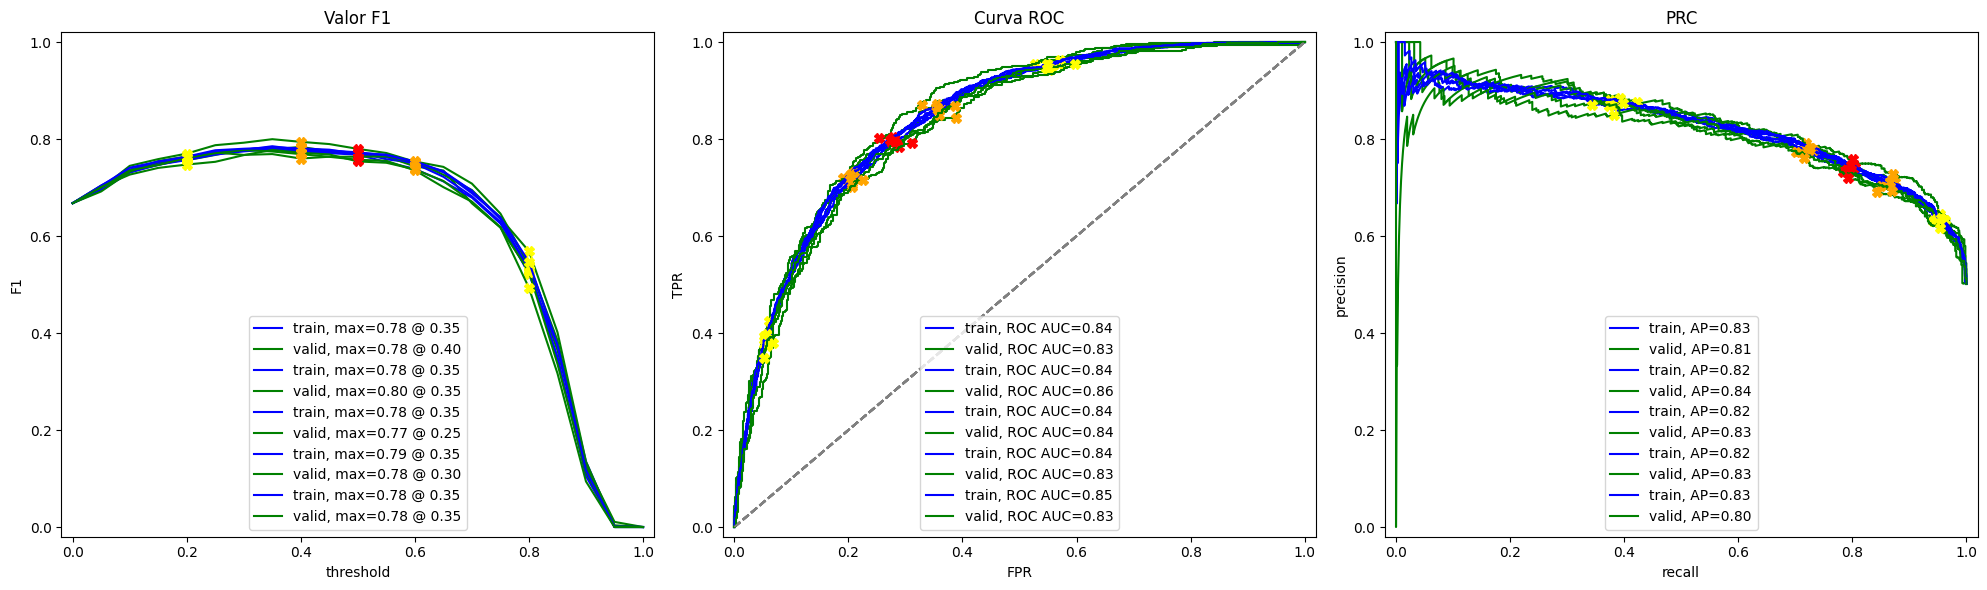

In [54]:
# Importamos el modelo
from sklearn.linear_model import LogisticRegression

# Definimos el modelo
lr_model = LogisticRegression(random_state=12345)

# Evaluamos el modelo
lr_results = evaluate_model_cv(
	lr_model,
	ordinal_features_train.to_numpy(),
	target_train.to_numpy(),
	cv_splits=5
)

Con base en los resultados, podemos determinar que el modelo no logra superar la expectativa del objetivo para la métrica ROC AUC de 0.88, aunque sus resultados no están muy lejanos a este umbral. Los niveles de sobreajuste son bajos y podemos definir un nivel de threshold de 0.35 si queremos un modelo balanceado a F1 o un poco menor (0.3) si queremos potenciar un poco más el recall.

### 4.2. Bosque Aleatorio de Clasificación <a id='random_forest'></a>

El modelo de bosque aleatorio se entrenará con un estudio de hiperparámetros, en el cual se evaluarán los siguientes parámetros:
- `n_estimators`: número de árboles en el bosque.
- `max_depth`: profundidad máxima de los árboles.

La métrica de evaluación será la exactitud, y se utilizará validación cruzada en 5 pliegues para determinar los hiperparámetros. Posteriormente se evaluara el rendimiento del modelo con los resultados obtenidos.

In [55]:
# Importando el modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Realizando estudio de hiperparámetros basado en la exactitud.
best_acc = 0
best_est = 0
best_depth = 0

for est in range(5, 105, 5):
    for depth in range(1, 11, 1):
        rfc_model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        
        rfc_model.fit(ohe_features_train, target_train)
        
        acc = cross_val_score(
            rfc_model, 
            ohe_features_train, 
            target_train, 
            cv=5,
            scoring='accuracy'
        )  
        
        acc = acc.mean()
            
        if acc > best_acc:
            best_acc = acc
            best_est = est
            best_depth = depth

print('Resultado de estudio de hiperparámetros:')
print('Mejor exactitud:', best_acc)
print(f'Dado con {best_est} estimadores de profundidad máxima {best_depth}')

Resultado de estudio de hiperparámetros:
Mejor exactitud: 0.8352828443138781
Dado con 80 estimadores de profundidad máxima 10


Folds totales: 5

Métricas promedio (validación cruzada):
           train  valid
Threshold   0.53   0.45
Accuracy    0.91   0.83
Recall      0.96   0.89
F1          0.91   0.84
F2          0.94   0.87
APS         0.97   0.91
ROC AUC     0.97   0.91

Sobreajuste promedio: 0.07


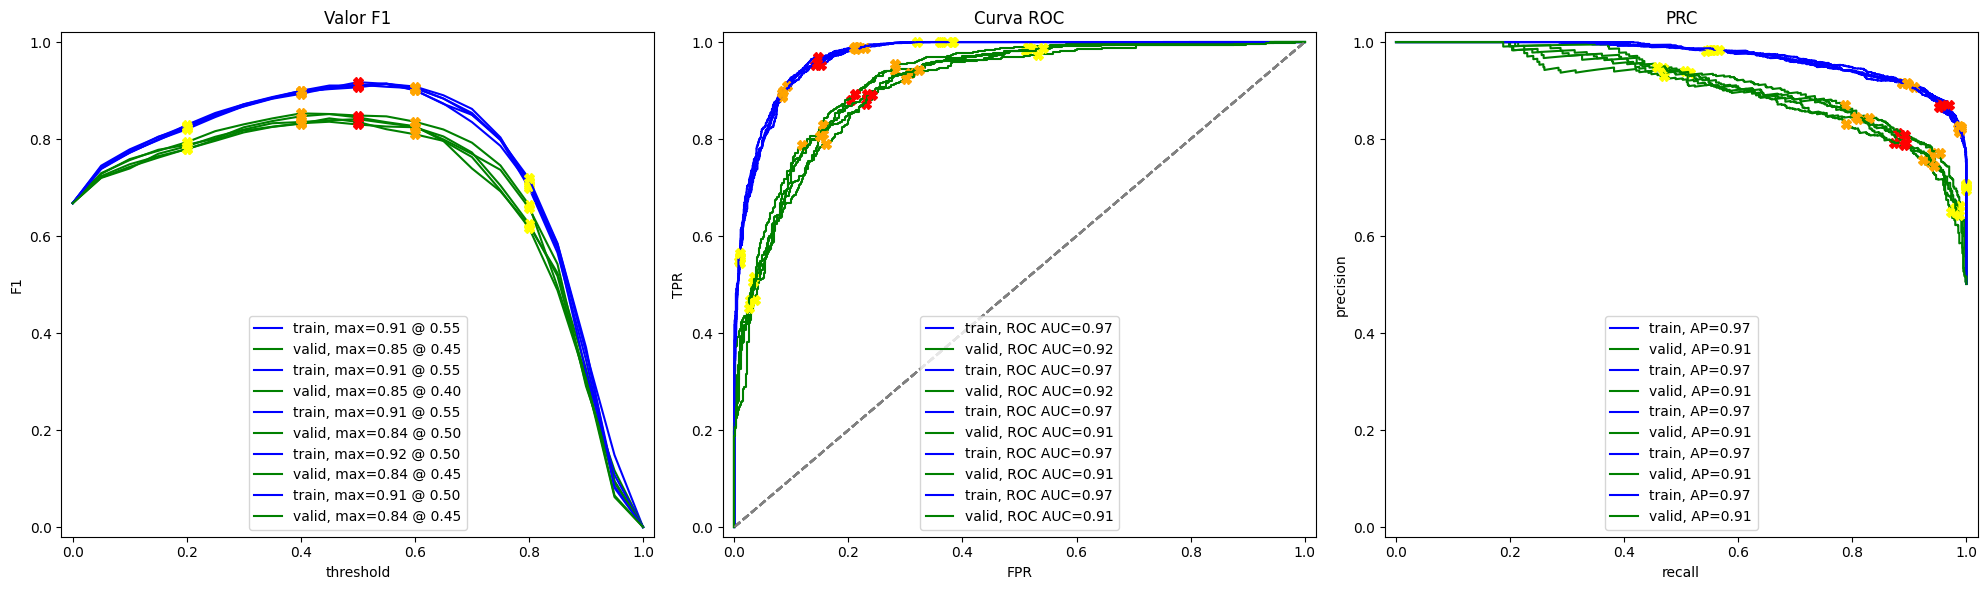

In [56]:
# Entrenamos en base a los resultados de los hiperparámetros
rfc_model = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=12345)

# Evaluamos el modelo
rfc_results = evaluate_model_cv(
    rfc_model, 
    ohe_features_train.to_numpy(),
    target_train.to_numpy(),
    cv_splits=5
)


El resultado de este modelo supera el umbral objetivo de ROC AUC con 0.91. Podemos deducir que el modelo tiene un sobreajuste medio. Para el threshold podemos definirlos en un valor entre 0.4 si deseamos enfocarnos en mejorar el recall o 0.45 si deseamos mantener un balance más conservador y optimizar F1.

### 4.3. XGBoost Classifier <a id='xgboost'></a>

En el modelo de potenciación de gradiente XGBoost se realizará una evaluación de un modelo sin hiperparámetros, para posteriormente evaluar qué hiperparámetros adecuar al modelo. La evaluación se mantendrá en las métricas de exactitud, recall, F1, F2, APS y AUC-ROC. Se utilizará validación cruzada en 5 pliegues para evaluar el modelo.

Folds totales: 5

Métricas promedio (validación cruzada):
           train  valid
Threshold   0.48   0.55
Accuracy    0.99   0.89
Recall      0.99   0.91
F1          0.99   0.90
F2          0.99   0.90
APS         1.00   0.96
ROC AUC     1.00   0.96

Sobreajuste promedio: 0.07


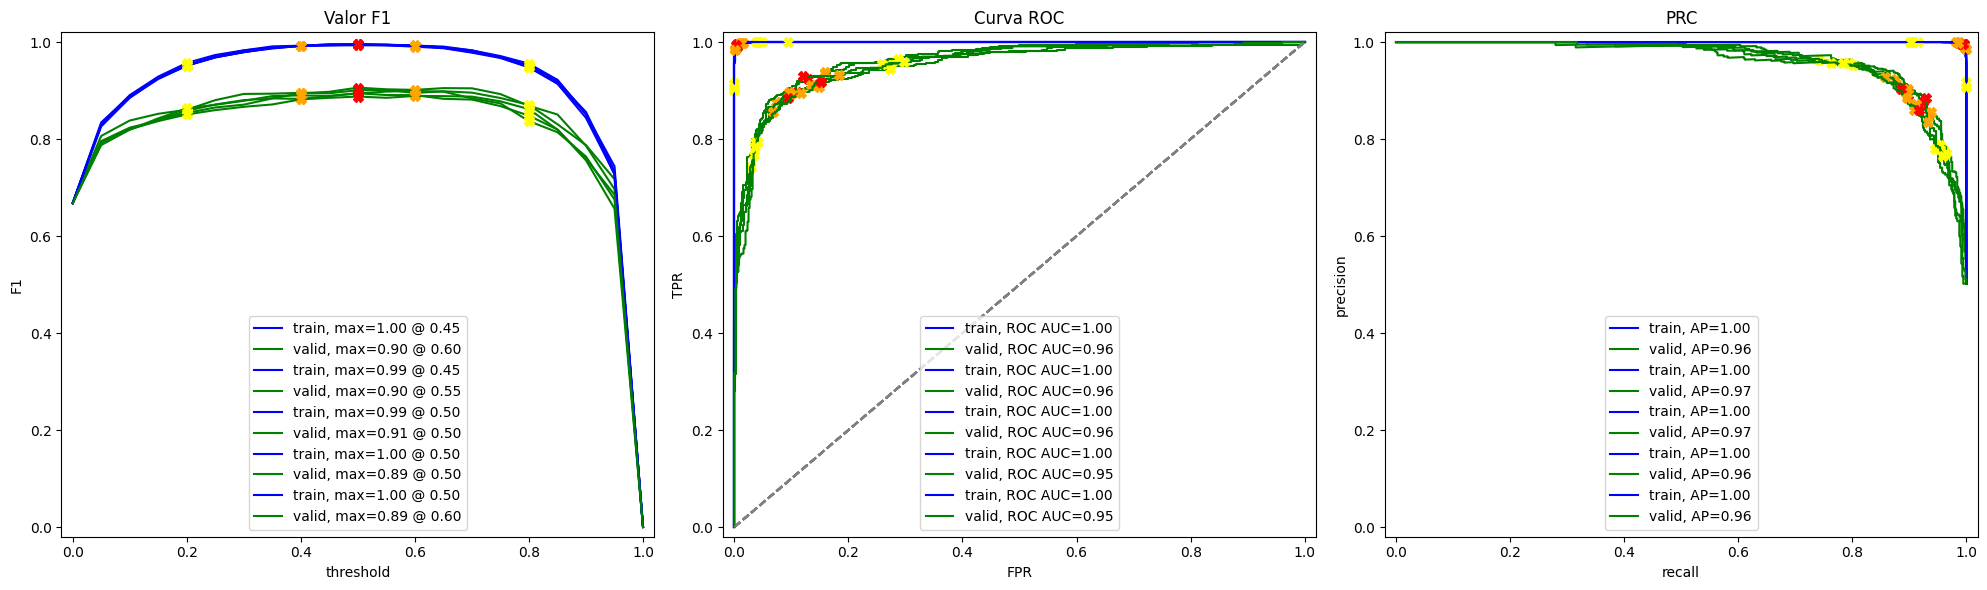

In [57]:
# Importamos el modelo
from xgboost import XGBClassifier

# Definimos el modelo sin hiperparámetros
xg_model = XGBClassifier(random_state=12345)

# Evaluamos el modelo
xg_results = evaluate_model_cv(
    xg_model, 
    ohe_features_train.to_numpy(),
    target_train.to_numpy(),
    cv_splits=5
)

El modelo muestra el mejor valor en ROC AUC hasta el momento con 0.96, superando el umbral objetivo de 0.88. El modelo presenta un sobreajuste medio, lo que indica que podríamos trabajar en hacer que generalice mejor las predicciones a costa de reducir un poco su desempeño. Para eso limitaremos la profundidad máxima a 4 niveles, aumentaremos el peso mínimo de las hojas a 5, y agregaremos una penalización L2 con un valor de 1. Con estos hiperparámetros, el modelo mantiene un buen desempeño y reduce el sobreajuste.

Folds totales: 5

Métricas promedio (validación cruzada):
           train  valid
Threshold   0.48   0.46
Accuracy    0.88   0.83
Recall      0.89   0.85
F1          0.88   0.83
F2          0.89   0.84
APS         0.96   0.93
ROC AUC     0.96   0.92

Sobreajuste promedio: 0.04


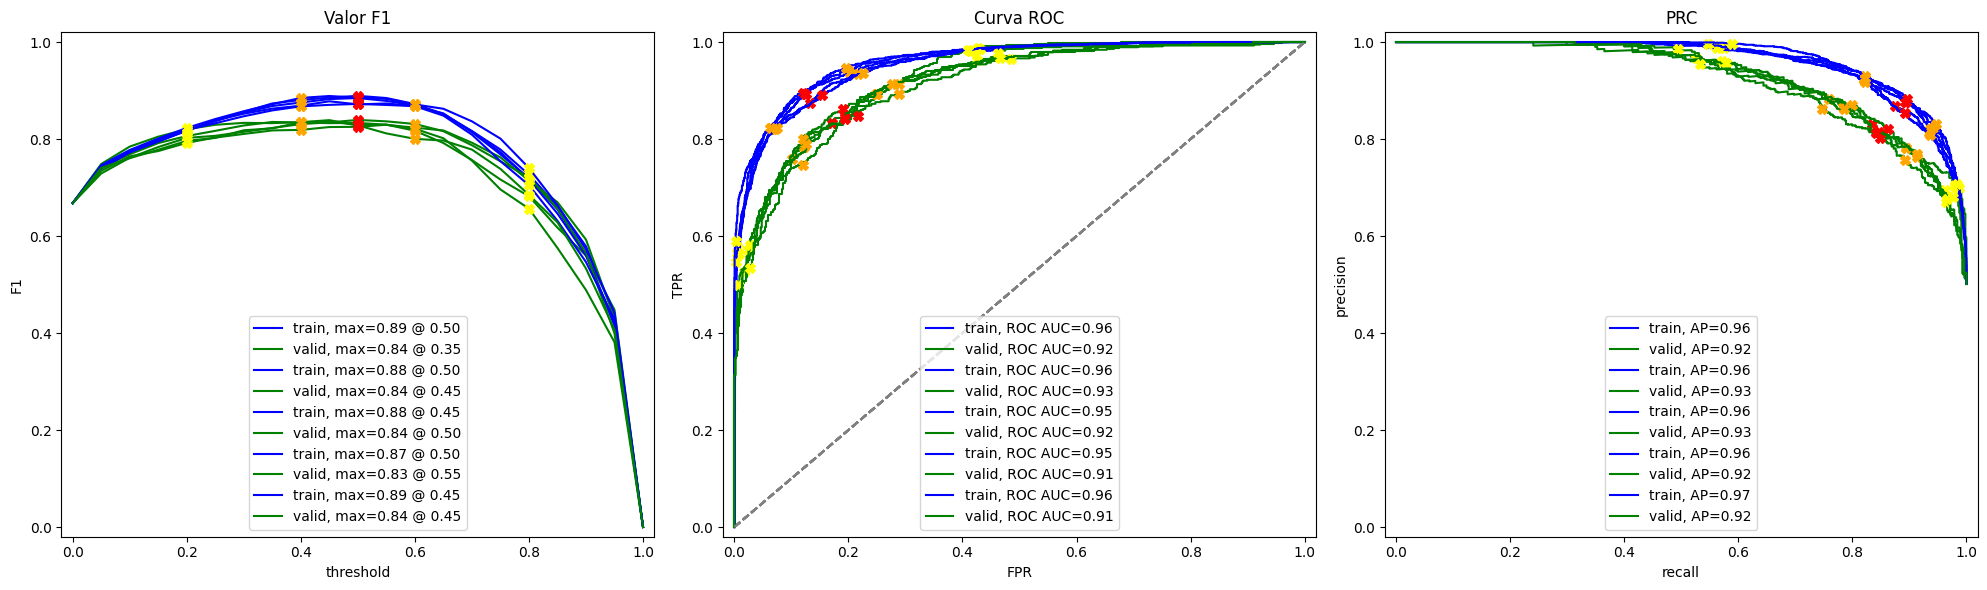

In [58]:
# Definimos el modelo con hiperparámetros
xg_model_2 = XGBClassifier(max_depth=4, min_child_weight=5, gamma=1, reg_lambda=1, random_state=12345)

# Evaluamos el modelo
xg_results_2 = evaluate_model_cv(
    xg_model_2, 
    ohe_features_train.to_numpy(),
    target_train.to_numpy(),
    cv_splits=5
)

Gracias al ajuste de hiperparámetros, logramos reducir el sobreajuste del modelo, manteniendo un buen desempeño en las métricas y acertando en el objetivo de mantener el ROC AUC sobre 0.88. Podemos definir un threshold entre 0.46 y 0.4 si queremos un modelo balanceado a F1 o un poco menor (0.35) si queremos potenciar un poco más el recall.

## 5. Predicciones en el conjunto de prueba <a id='predict_test'></a>

### 5.1. Selección del modelo <a id='model_select'></a>

Para seleccionar el modelo que se utilizará para las predicciones finales, se evaluarán los resultados de los modelos entrenados en el conjunto de validación, comparándolos por las métricas principales para el proyecto: ROC AUC y exactitud, teniendo en cuenta sobreajuste.

In [59]:
# Resumen del desempeño de todos los modelos
model_summary = pd.DataFrame()

for model_name, results, overfit in zip(
    ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'XGBoost_Tuned'], 
    [lr_results, rfc_results, xg_results, xg_results_2],
    [0.01, 0.07, 0.07, 0.04]
):    
    model = results.drop('Threshold').drop('train', axis=1).rename(columns={'valid': model_name})
    model.loc['Overfitting', model_name] = overfit
    model_summary = pd.concat([model_summary, model], axis=1)

model_summary = model_summary.transpose()
model_summary

,Accuracy,Recall,F1,F2,APS,ROC AUC,Overfitting
Logistic_Regression,0.76,0.79,0.76,0.78,0.82,0.84,0.01
Random_Forest,0.83,0.89,0.84,0.87,0.91,0.91,0.07
XGBoost,0.89,0.91,0.90,0.90,0.96,0.96,0.07
XGBoost_Tuned,0.83,0.85,0.83,0.84,0.93,0.92,0.04


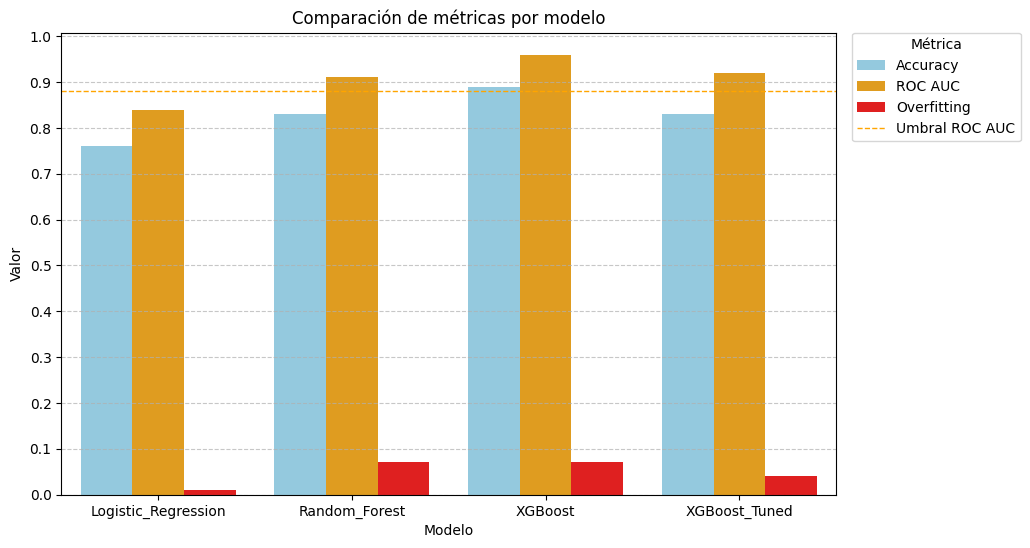

In [60]:
# Pasar de formato ancho a largo
df_long = model_summary[['Accuracy', 'ROC AUC', 'Overfitting']].reset_index().melt(
    id_vars='index', 
    var_name='Métrica', 
    value_name='Valor'
)

# Mapa de colores personalizado para cada métrica
palette = {
    'Accuracy': 'skyblue',
    'ROC AUC': 'orange',
    'Overfitting': 'red'
}

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_long,
    x='index', 
    y='Valor',
    hue='Métrica',
    palette=palette
)

# Linea de umbral para ROC AUC
plt.axhline(y=0.88, color='orange', linestyle='--', linewidth=1, label='Umbral ROC AUC')

# Etiquetas y titulos
plt.xticks(rotation=0)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparación de métricas por modelo')
plt.legend(
    title='Métrica', 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left',
    borderaxespad=0.
)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Se elegirá el modelo **XGBoost_Tuned** (xg_model_2) por su desempeño y sobreajuste equilibrado. Fue este modelo quien mantuvo valores por encima del umbral de selección de ROC AUC (0.88) con el menor valor de sobreajuste, lo que le permite generalizar mejor las predicciones.

### 5.2. Predicciones y evaluación del modelo <a id='model_eval'></a>

Mediremos nuevamente el desempeño del modelo seleccionado en el conjunto de pruebas a través de las métricas y el umbral que consideramos más balanceado (0.45 para el modelo xg_model_2).

In [61]:
# Definición de una función para evaluar los modelos a través de diferentes métricas
import sklearn.metrics as metrics

def evaluate_model_test(model, train_features, train_target, test_features, test_target, threshold_train):

    model.fit(train_features, train_target)
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    type = 'test'
    features = test_features
    target = test_target

    eval_stats[type] = {}

    pred_proba = model.predict_proba(features)[:, 1]
    pred_target = [1 if x >= threshold_train else 0 for x in pred_proba]

    # F1
    f1_thresholds = np.arange(0, 1.01, 0.05)
    f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

    # ROC
    fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
    roc_auc = metrics.roc_auc_score(target, pred_proba)
    eval_stats[type]['ROC AUC'] = roc_auc

    # PRC
    precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
    aps = metrics.average_precision_score(target, pred_proba)
    eval_stats[type]['APS'] = aps

    if type == 'train':
        color = 'blue'
    else:
        color = 'green'

    # Valor F1
    ax = axs[0]
    max_f1_score_idx = np.argmax(f1_scores)
    ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
    ax.axvline(threshold_train, color='red', linestyle='--', label='Umbral entrenado')
    # establecer cruces para algunos umbrales
    for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
        closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
        marker_color = 'orange' if threshold != 0.5 else 'red'
        ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('threshold')
    ax.set_ylabel('F1')
    ax.legend(loc='lower center')
    ax.set_title(f'Valor F1')

    # ROC
    ax = axs[1]
    ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
    ax.axvline(fpr[np.argmin(np.abs(roc_thresholds-threshold_train))], color='red', linestyle='--', label='Umbral entrenado')
    # establecer cruces para algunos umbrales
    for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
        closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
        marker_color = 'orange' if threshold != 0.5 else 'red'
        ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend(loc='lower center')
    ax.set_title(f'Curva ROC')

    # PRC
    ax = axs[2]
    ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
    ax.axvline(recall[np.argmin(np.abs(pr_thresholds-threshold_train))], color='red', linestyle='--', label='Umbral entrenado')
    # establecer cruces para algunos umbrales
    for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
        closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
        marker_color = 'orange' if threshold != 0.5 else 'red'
        ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.legend(loc='lower center')
    ax.set_title(f'PRC')

    eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    eval_stats[type]['Recall'] = metrics.recall_score(target, pred_target)
    eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    eval_stats[type]['F2'] = metrics.fbeta_score(target, pred_target, beta=2)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'Recall', 'F1', 'F2', 'APS', 'ROC AUC'))

    print(df_eval_stats)
    
    return df_eval_stats

          test
Accuracy  0.85
Recall    0.90
F1        0.85
F2        0.88
APS       0.94
ROC AUC   0.94


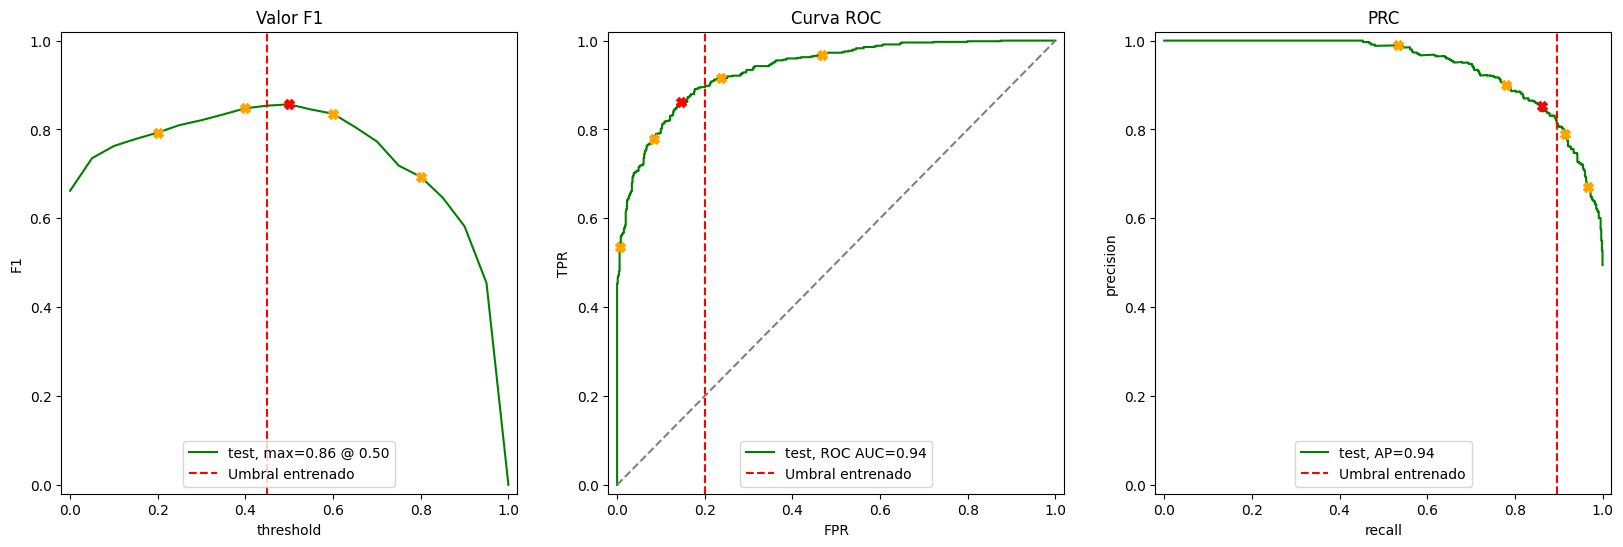

In [62]:
# Evaluamos el modelo
xg_results_2 = evaluate_model_test(
    xg_model_2, 
    ohe_features_train.to_numpy(),
    target_train.to_numpy(),
    ohe_features_test.to_numpy(),
    target_test.to_numpy(),
    threshold_train=0.45
)

Obtuvimos un resultado competente en la métrica principal ROC AUC de 0.94 y en la métrica de exactitud de 0.85. También cabe resaltar que la métrica recall se mantiene alta con un valor de 0.9.

## Conclusiones <a id='end'></a>

- Un evento a finales del 2019 generó una activación tanto de subscripciones de nuevos usuarios como abandono de los mismos, siendo el segundo caso el de mayor fuerza, resultando en un descenso del total de clientes para la compañía.
- Solo se tiene registro de abandono de los clientes en los últimos meses, es decir, de octubre del 2019 a enero del 2020.
- El modelo de potenciación de gradiente con ajuste en hiperparámetros para el control de sobre ajuste fue el seleccionado por su balance entre rendimiento, calidad y robustez de predicción.
- El modelo logró superar las expectativas propuestas para la métrica ROC AUC (0.88) con un desempeño de 0.94 en el conjunto de pruebas.
- La métrica secundaria del modelo, exactitud, mostró un valor de 0.85. También cabe resaltar el recall, el cual alcanzó un valor de 0.9 en el conjunto de pruebas.